# 2024 COMP90042 Project

# Readme

This Notebook is expected to be run on Google Colab.
Please maintain this folder structure on your drive.
```
| COMP90042_Project/
   |__ model/
   |__ result/
   |__ data/  (store raw dataset here)
   |__ train_data/
```
The data generation section for evidence retrieval training will exceed the RAM limit on Colab free version, so we generate train data and train the models by parts. Restart the session to clear the memory if necessary. The total size of data generated will exceed 130GB. To mitigate this storage issue, we can upgrade the storage of Google Drive or execute the Notebook by parts and delete redundant data after used.

Since the training data generation for the ER model and the ER model training are computationally expensive, please understand that it is not feasible for us to rerun all the code to retain the logging throughout the training of the ER model. However, we have rerun the ER dev set evaluation to show the evaluation logging and support our performance in the report.

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder = 'drive/MyDrive/COMP90042_Project/'

model_dir = 'model/'
result_dir = 'result/'
data_dir = 'data/'
train_data_dir = 'train_data/'

Mounted at /content/drive


In [ ]:
import json
import os

def load_data(filename):
    """Load JSON data from a file."""
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def preprocess_data(data):
    """Extract claims and evidence from the dataset."""
    processed_data = []
    for claim_id, claim_info in data.items():
        claim_text = claim_info.get('claim_text', '')
        claim_label = claim_info.get('claim_label', None)  # None for unlabelled data
        evidences = claim_info.get('evidences', [])
        processed_data.append({
            'claim_id': claim_id,
            'claim_text': claim_text,
            'claim_label': claim_label,
            'evidences': evidences
        })
    return processed_data

# Paths to the data files
train_path = os.path.join(folder + data_dir + 'train-claims.json')
dev_path = os.path.join(folder + data_dir + 'dev-claims.json')
test_path = os.path.join(folder + data_dir + 'test-claims-unlabelled.json')
evidence_path = os.path.join(folder + data_dir + 'evidence.json')

# Load the datasets
train_data = load_data(train_path)
dev_data = load_data(dev_path)
test_data = load_data(test_path)
evidence_data = load_data(evidence_path)

# Preprocess the data
train_claims = preprocess_data(train_data)
dev_claims = preprocess_data(dev_data)
test_claims = preprocess_data(test_data)

print('Number of train claims:', len(train_claims))
print('Number of dev claims:', len(dev_claims))
print('Number of test claims:', len(test_claims))
print('Number of evidence:', len(evidence_data))

print('One train_claims(list):', train_claims[0])
print('One evidence_data(dict):', list(evidence_data.items())[0])

Number of train claims: 1228
Number of dev claims: 154
Number of test claims: 153
Number of evidence: 1208827
One train_claims(list): {'claim_id': 'claim-1937', 'claim_text': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.', 'claim_label': 'DISPUTED', 'evidences': ['evidence-442946', 'evidence-1194317', 'evidence-12171']}
One evidence_data(dict): ('evidence-0', 'John Bennet Lawes, English entrepreneur and agricultural scientist')


In [ ]:
# train a word2vec word embedding model
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import string
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

def preprocess_tokenize(sentence):
    tokens = word_tokenize(sentence.lower())
    output = []
    for t in tokens:
        t_ = lemmatize(t)
        if t_ in stop_words or t_ in string.punctuation: continue
        else:
            output.append(t_)
    return output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Train Word2Vec Embedding**

In [ ]:
def add_tokenized_sentences(row, tokenized_sentences, trained_ev):
    claim = row['claim_text']
    checked_ev = []
    for eid1 in row['evidences']:
        checked_ev.append(eid1)
        trained_ev.append(eid1)
        tokenized_sentences.append(preprocess_tokenize(claim + evidence_data[eid1]))
        for eid2 in row['evidences']:
            if eid2 not in checked_ev:
                tokenized_sentences.append(preprocess_tokenize(evidence_data[eid1] + evidence_data[eid2]))

# distinct evidence and claims
tokenized_sentences = []

# claims and related evidences concatenated together
trained_ev = []
for row in train_claims:
    add_tokenized_sentences(row, tokenized_sentences, trained_ev)
for row in dev_claims:
    add_tokenized_sentences(row, tokenized_sentences, trained_ev)

for eid, ev in evidence_data.items():
    if eid not in trained_ev:
        tokenized_sentences.append(preprocess_tokenize(ev))

In [ ]:
embed_size = 128
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=embed_size, window=30, min_count=1, workers=4)
word2vec_model.save(folder + model_dir + "word2vec_model_pair")

Load Word2Vec model if it is trained before

In [ ]:
embed_size = 128
word2vec_model = Word2Vec.load(folder + model_dir + "word2vec_model_pair")

vocab_size = len(word2vec_model.wv.key_to_index)
print(vocab_size)

708978


**Train KNN for Evidence Filtering**

In [ ]:
import numpy as np

# calculate sentence embedding as average of word embedding
def sentence_embedding(sentence, words = None):
    if words is None:
        words = preprocess_tokenize(sentence)
    words_copy = words.copy()
    word_embeddings = []
    # Iterate over each word in the sentence
    for word in words:
        # Check if the word is present in the vocabulary of the Word2Vec model
        if word in word2vec_model.wv.key_to_index:
            word_embedding = word2vec_model.wv[word]
            word_embeddings.append(word_embedding)
        else:
          words_copy.remove(word)
    # Calculate the average word embedding (sentence embedding)
    if word_embeddings:
        word_embeddings = np.array(word_embeddings)
        # sent_embedding = np.sum(word_embeddings, axis=0) # same as average, sum by column
        #sent_embedding = np.max(word_embeddings, axis=0)
        return word_embeddings, words_copy
    else:
        return None, words_copy

claim_text = train_claims[0]['claim_text']
evidence_text = evidence_data[train_claims[0]['evidences'][0]]
claim_embedding, _ = sentence_embedding(claim_text)
evidence_embedding, _= sentence_embedding(evidence_text)
print(np.array(claim_embedding).shape)
print(np.array(evidence_embedding).shape)

(14, 128)
(26, 128)


In [ ]:
def sentence_embedding_avg(sentence, words = None):
    if words is None:
        words = preprocess_tokenize(sentence)
    word_embeddings = []
    # Iterate over each word in the sentence
    for word in words:
        # Check if the word is present in the vocabulary of the Word2Vec model
        if word in word2vec_model.wv.key_to_index:
            word_embedding = word2vec_model.wv[word]
            word_embeddings.append(word_embedding)
    # Calculate the average word embedding (sentence embedding)
    if word_embeddings:
        word_embeddings = np.array(word_embeddings)
        sent_embedding = np.sum(word_embeddings, axis=0) # same as average, sum by column
        #sent_embedding = np.max(word_embeddings, axis=0)
        return sent_embedding.reshape(1, -1)
    else:
        return None

In [ ]:
# produce sentence embeddings of the evidences
evidence_embeddings_avg = []
evidence_ids_avg = []
for eid, etext in evidence_data.items():
    embed = sentence_embedding_avg(etext)
    if embed is not None:
        evidence_embeddings_avg.append(embed[0])
        evidence_ids_avg.append(eid)
evidence_embeddings_avg = np.array(evidence_embeddings_avg)
evidence_ids_avg = np.array(evidence_ids_avg)

In [ ]:
import json
from sklearn.neighbors import NearestNeighbors
import pickle

# Initialize kNN model
k = 3000  # Number of neighbors
knn_model = NearestNeighbors(n_neighbors=k, metric='cosine')

# Fit kNN model with sentence embeddings
knn_model.fit(evidence_embeddings_avg)

with open(folder + model_dir + 'evidences_ids_avg.json', 'w') as f:
    json.dump(evidence_ids_avg.tolist(), f)

with open(folder + model_dir + '3000nn.pkl', 'wb') as f:
    pickle.dump(knn_model,f)

Load KNN if it was fitted before

In [ ]:
import pickle
import json

with open(folder + model_dir + 'evidences_ids_avg.json', 'r') as f:
    evidence_ids_avg = json.load(f)

with open(folder + model_dir + '3000nn.pkl', 'rb') as f:
    knn_model = pickle.load(f)

Prepare Train/Dev/TrainDev/Test Data for Evidence Retrieval (WARNING: high RAM usage)

In [ ]:
import pandas as pd
import random

def gen_train_data(claims, neg_samples_num, dataset_name, part):
  train_data = []

  for claim in claims:
      print(f'Preparing {dataset_name} data part {part} {claim["claim_id"]}')

      train_data_for_this_claim_id = {'claim_id': claim['claim_id'], 'true_evidences': claim['evidences']}
      train_sample_for_this_claim_id = []

      claim_embedding, _ = sentence_embedding(claim['claim_text'])
      claim_embedding_avg = sentence_embedding_avg(claim['claim_text'])
      if claim_embedding is None:
          continue
      distances, indices = knn_model.kneighbors(claim_embedding)
      nearest_neighbor_ids = [evidence_ids_avg[i] for i in indices.flatten()]

      # positive sampling
      for ev_id in claim['evidences']:
          ev = evidence_data[ev_id]
          ev_embedding, _ = sentence_embedding(ev)
          if ev_embedding is None:
              continue
          train_sample_for_this_claim_id.append([claim_embedding] + [ev_embedding] + [1] + [ev_id])

       # negative sampling
      neg_sample_count = 0
      while neg_sample_count < neg_samples_num:
          neighbor_id = random.choice(nearest_neighbor_ids)
          if neighbor_id in claim['evidences']:
              continue
          evidence = evidence_data[neighbor_id]
          evidence_embedding, _ = sentence_embedding(evidence)
          if evidence_embedding is None:
              continue
          train_sample_for_this_claim_id.append([claim_embedding] + [evidence_embedding] + [0] + [neighbor_id])
          neg_sample_count += 1
          nearest_neighbor_ids.remove(neighbor_id)

      train_data_for_this_claim_id['evidence_samples'] = train_sample_for_this_claim_id

      train_data.append(train_data_for_this_claim_id)

  np.save(folder + train_data_dir + f'{dataset_name}_data_{part}_{neg_samples_num}neg', train_data)
  print(f'Saved {dataset_name} data part {part} {neg_samples_num}neg')

trainDev_claims = np.array(train_claims + dev_claims)
trainDev_claims_parts = np.array_split(trainDev_claims, 8)
train_claims_parts = np.split(np.array(train_claims), 8)

# In case of OOM, we can restart the loop from the OOM job
for i in range(8):
  for neg_sample_num in [1500, 1200, 1000]:
    gen_train_data(train_claims_parts[i], neg_sample_num, 'train', i+1)

for i in range(8):
  for neg_sample_num in [1500, 1200, 1000]:
    gen_train_data(trainDev_claims_parts[i], neg_sample_num, 'trainDev', i+1)

In [ ]:
import random

dev_data = []

for claim in dev_claims:
    print('Preparing dev data', claim['claim_id'])

    dev_data_for_this_claim_id = {'claim_id': claim['claim_id'], 'true_evidences': claim['evidences']}
    dev_sample_for_this_claim_id = []

    claim_embedding, _ = sentence_embedding(claim['claim_text'])
    claim_embedding_avg = sentence_embedding_avg(claim['claim_text'])
    if claim_embedding is None:
        continue
    distances, indices = knn_model.kneighbors(claim_embedding_avg)
    nearest_neighbor_ids = [evidence_ids_avg[i] for i in indices.flatten()]

    for neighbor_id in nearest_neighbor_ids:
        if neighbor_id in claim['evidences']:
            label = 1
        else:
            label = 0
        evidence = evidence_data[neighbor_id]
        evidence_embedding, _ = sentence_embedding(evidence)
        if evidence_embedding is None:
            continue
        dev_sample_for_this_claim_id.append([claim_embedding] + [evidence_embedding] + [label] + [neighbor_id])

    dev_data_for_this_claim_id['evidence_samples'] = dev_sample_for_this_claim_id

    dev_data.append(dev_data_for_this_claim_id)

np.save(folder + train_data_dir + 'dev_data_3000nn', dev_data)

Preparing dev data claim-752
Preparing dev data claim-375
Preparing dev data claim-1266
Preparing dev data claim-871
Preparing dev data claim-2164
Preparing dev data claim-1607
Preparing dev data claim-761
Preparing dev data claim-1718
Preparing dev data claim-1273
Preparing dev data claim-1786
Preparing dev data claim-2796
Preparing dev data claim-2580
Preparing dev data claim-1219
Preparing dev data claim-75
Preparing dev data claim-2813
Preparing dev data claim-2335
Preparing dev data claim-161
Preparing dev data claim-2243
Preparing dev data claim-1256
Preparing dev data claim-506
Preparing dev data claim-369
Preparing dev data claim-2184
Preparing dev data claim-1057
Preparing dev data claim-104
Preparing dev data claim-1975
Preparing dev data claim-139
Preparing dev data claim-2062
Preparing dev data claim-1160
Preparing dev data claim-2679
Preparing dev data claim-2662
Preparing dev data claim-1490
Preparing dev data claim-2768
Preparing dev data claim-2168
Preparing dev data cl

In [ ]:
import random

def get_test_data(claims, dataset_name, part=None):
  test_data = []

  for claim in claims:
      print('Preparing test data', claim['claim_id'])

      test_data_for_this_claim_id = {'claim_id': claim['claim_id']}
      test_sample_for_this_claim_id = []

      claim_embedding, _ = sentence_embedding(claim['claim_text'])
      claim_embedding_avg = sentence_embedding_avg(claim['claim_text'])
      if claim_embedding is None:
          continue
      distances, indices = knn_model.kneighbors(claim_embedding_avg)
      nearest_neighbor_ids = [evidence_ids_avg[i] for i in indices.flatten()]

      for neighbor_id in nearest_neighbor_ids:
          evidence = evidence_data[neighbor_id]
          evidence_embedding, _ = sentence_embedding(evidence)
          if evidence_embedding is None:
              continue
          test_sample_for_this_claim_id.append([claim_embedding] + [evidence_embedding] + [0] + [neighbor_id])

      test_data_for_this_claim_id['evidence_samples'] = test_sample_for_this_claim_id

      test_data.append(test_data_for_this_claim_id)
  if part is None:
    filename = f'{dataset_name}_data_3000nn'
  else:
    f'{dataset_name}_data_{part}_3000nn'
  np.save(folder + train_data_dir + filename, test_data)

# Get the test data for test claims
get_test_data(test_claims, 'test')

# Get the 3000nn for train claims by part to avoid Out of Memory
# This set is for predicting the ER for train claims and will be used for claim verification training
train_claims_parts = np.array_split(np.array(train_claims), 8)
for i, train_claims_part in enumerate(train_claims_parts):
  get_test_data(train_claims_part, 'train', i + 1)

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

**Evidence Retrieval**

In [ ]:
import torch
from torch.utils.data import DataLoader

# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print('Device:', device)
torch.set_default_device(device)

padding_embedding = [0.0] * 128 # 128 is the word embedding dimension

def seq_collate_batch(batch):
    claim_list, evidence_list, label_list, evidence_id_list = [], [], [], []
    for record in batch:
        claim_list.append(record[0])
        evidence_list.append(record[1])
        label_list.append(record[2])
        evidence_id_list.append(record[3])

    claim_text_tensor = []
    for claim in claim_list:
        padded_seq = torch.tensor(claim[:claim_max_len], dtype=torch.float32)
        add_padding = torch.tensor([padding_embedding] * (claim_max_len - len(padded_seq)), dtype=torch.float32)
        padded_seq = torch.concat((padded_seq, add_padding), dim=0)
        claim_text_tensor.append(padded_seq)
    claim_list = torch.stack(claim_text_tensor)

    evidence_list_tensor = []
    for evidence in evidence_list:
        padded_seq = torch.tensor(evidence[:evidence_max_len], dtype=torch.float32)
        add_padding = torch.tensor([padding_embedding] * (evidence_max_len - len(padded_seq)), dtype=torch.float32)
        padded_seq = torch.concat((padded_seq, add_padding), dim=0)
        evidence_list_tensor.append(padded_seq)
    evidence_list = torch.stack(evidence_list_tensor)

    label_list = torch.tensor(label_list, dtype=torch.float32)

    # print(claim_list.shape, evidence_list.shape, label_list.shape)

    # Stack all sequences into a single tensor for each batch
    return claim_list.to(device), evidence_list.to(device), label_list.reshape(-1, 1).to(device), evidence_id_list

claim_max_len = 40
evidence_max_len = 100
batch_size_train = 256
batch_size_dev = 256

def flatten_data(data):
  flatten_train_data = []
  for data_for_one_claim_id in data:
    flatten_train_data += data_for_one_claim_id['evidence_samples']
  return flatten_train_data

Device: cuda


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ERModel(nn.Module):

    def __init__(self, d0):
        super().__init__()
        self.d0 = d0
        self.d1 = d0
        self.d2 = self.d1*2
        self.d3 = self.d2
        self.d4 = self.d3*2
        self.lstm1 = nn.LSTM(d0, self.d1, batch_first=True, bidirectional=True)
        self.alignment_linear = nn.Linear(self.d1*2*4, self.d2)
        self.relu = nn.ReLU()
        self.lstm2 = nn.LSTM(self.d2 + d0, self.d3, batch_first=True, bidirectional=True)
        self.output_linear1 = nn.Linear(self.d3*2*4, self.d4)
        self.output_linear2 = nn.Linear(self.d4, 1)

    def max_pool_row(self, input_tensor):
        input_tensor = input_tensor.unsqueeze(0)
        pool = nn.MaxPool2d(kernel_size=(1, input_tensor.shape[-1]))

        output = pool(input_tensor)
        output = output.view(output.shape[1], output.shape[2])

        return output

    # process by batch
    def forward(self, claim_embedding, evidence_embedding):

        # print('embedding shape:', claim_embedding.shape, evidence_embedding.shape)

        # batch_size x seq_len x d0*2
        U, (hidden, cell) = self.lstm1(claim_embedding)
        V, (hidden, cell) = self.lstm1(evidence_embedding)
        # print('U and V', U.shape, V.shape)

        E = torch.bmm(U, V.transpose(1, 2))

        # batch_size x claim_len x evidence_len
        E_softmax_col = F.softmax(E, dim=1)
        E_softmax_col_t = F.softmax(E.transpose(1, 2), dim=1)
        # print('E_softmax:', E_softmax_col.shape, E_softmax_col_t.shape)

        # batch_size x claim_len x d0*2
        U_tilde = torch.bmm(V.transpose(1, 2), E_softmax_col_t).transpose(1, 2)
        V_tilde  = torch.bmm(U.transpose(1, 2), E_softmax_col).transpose(1, 2)
        # print('U_tilde:', U_tilde.shape, 'V_tilde:', V_tilde.shape)

        concated_U = torch.cat((U, U_tilde, U - U_tilde, U * U_tilde), dim=2)
        concated_V = torch.cat((V, V_tilde, V - V_tilde, V * V_tilde), dim=2)
        # print('concated:', concated_U.shape, concated_V.shape)

        S_alignment_linear_out = self.alignment_linear(concated_U)
        T_alignment_linear_out = self.alignment_linear(concated_V)

        # batch_size x claim_len x d0*2
        S = self.relu(S_alignment_linear_out)
        T = self.relu(T_alignment_linear_out)
        # print('S T', S.shape, T.shape)

        P, (hidden, cell) = self.lstm2(torch.cat((S, claim_embedding), dim=2))
        Q, (hidden, cell) = self.lstm2(torch.cat((T, evidence_embedding), dim=2))
        # batch_size x d3*2 x claim_len
        P = P.transpose(1, 2)
        Q = Q.transpose(1, 2)
        # print('P Q', P.shape, Q.shape)

        # batch_size x d3*2
        p = self.max_pool_row(P)
        q = self.max_pool_row(Q)
        # print('p q', p.shape, q.shape)

        final_concat = torch.cat((p, q, torch.abs(p - q), p * q), dim=1)

        linear1_out = self.output_linear1(final_concat)
        linear1_out = self.relu(linear1_out)

        # batch_size x 1
        linear2_out = self.output_linear2(linear1_out)
        # print('Output m:', linear2_out)

        logits = torch.sigmoid(linear2_out)

        return logits

In [ ]:
# train for one epoch, go through all the batches
def train(train_data, model, loss_fn, optimizer):

    # Calling .train() will evoke the tensor to start caching steps and gradients.
    model.train()

    # loop through each batch
    for batch_i, (claim_embedding, evidence_embedding, y, _) in enumerate(train_data):
        print('Training batch:', batch_i)
        # Compute prediction by directly calling the model variable.
        softmax_output = model(claim_embedding, evidence_embedding)

        # Calculate the loss by comparing the prediction and the true labels.
        loss = loss_fn(softmax_output, y)

        # Backpropagation: calculate the gradient by walking back the cached steps.
        loss.backward()

        # Update the parameters of the model with the loss gradient.
        optimizer.step()

        # Remove all the gradient to be ready for the next training of the next batch.
        optimizer.zero_grad()

In [ ]:
def test(data, model, loss_fn):
    num_batches = 0

    model.eval()
    test_loss = 0
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    num_claims = len(data)

    with torch.no_grad():
        for i, data_for_claim_id in enumerate(data):
          print('Testing claim:', i, data_for_claim_id['claim_id'])

          dataloader = DataLoader(data_for_claim_id['evidence_samples'], batch_size=batch_size_dev, collate_fn=seq_collate_batch)
          prediction_rank = []
          true_evidences = data_for_claim_id['true_evidences']
          num_batches += len(dataloader)

          for (claim_embedding, evidence_embedding, y, evidence_ids) in dataloader:
              pred = model(claim_embedding, evidence_embedding)
              test_loss += loss_fn(pred, y).item()
              pred = torch.flatten(pred)

              for i in range(len(y)):
                prediction_rank.append({'id': evidence_ids[i], 'prob': pred[i]})

          prediction_rank = sorted(prediction_rank, key=lambda d: d['prob'], reverse=True)
          top_4_evidence = [d['id'] for d in prediction_rank[:4]]
          num_found = len(set(top_4_evidence) & set(true_evidences))

          for prediction_dict in prediction_rank[:4]:
            id = prediction_dict['id']
            prob = prediction_dict['prob']

            if id in true_evidences:
              print(f'{id}: T, {prob}')
            else:
              print(f'{id}: F, {prob}')

          recall = num_found / len(true_evidences)
          precision = num_found / 4
          total_recall += recall
          total_precision += precision
          total_f1 += (2*recall*precision) / (recall + precision) if recall + precision != 0 else 0

    avg_loss = test_loss / num_batches
    recall = total_recall / num_claims
    precision = total_precision / num_claims
    f1 = total_f1 / num_claims
    print(f"Test Error: \n recall: {recall}, precision: {precision}, f1: {f1}, avg loss for each batch: {avg_loss:>8f} \n")

    return recall, precision, f1

Train for 3 epochs with annealed sampling

In [ ]:
import numpy as np

d0 = 128

model = ERModel(d0).to(device)
print(model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dev_data = np.load(folder + train_data_dir + 'dev_data_3000nn.npy', allow_pickle=True)

ERModel(
  (lstm1): LSTM(128, 128, batch_first=True, bidirectional=True)
  (alignment_linear): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (lstm2): LSTM(384, 256, batch_first=True, bidirectional=True)
  (output_linear1): Linear(in_features=2048, out_features=512, bias=True)
  (output_linear2): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
print("Training Evidence Retrieval model!")
neg_samples_nums = [1500, 1200, 1000]
recalls = []
precisions = []
f1s = []

for i, neg_samples_num in enumerate(neg_samples_nums):
  print('epoch', i+1)
  for part in range(8):
    train_data = np.load(folder + train_data_dir + f'train_data_{part+1}_{neg_samples_num}neg.npy', allow_pickle=True)
    flatten_train_data = flatten_data(train_data)
    train_dataloader = DataLoader(flatten_train_data, batch_size=batch_size_train, collate_fn=seq_collate_batch)
    print('Number of batch in train:', len(train_dataloader))

    train(train_dataloader, model, loss_fn, optimizer)

  recall, precision, f1 = test(dev_data, model, loss_fn)
  recalls.append(recall)
  precisions.append(precision)
  f1s.append(f1)

  torch.save({
            'epoch': i+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, folder + model_dir + f'er_train_epoch{i+1}_{neg_samples_num}neg.tar')

Plot the ER performance over epochs

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(neg_samples_nums) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, recalls, label='Recalls')
plt.plot(epochs, precisions, label='Precisions')
plt.plot(epochs, f1s, label='F1-score')

plt.title('Evidence Retrieval - Dev Recall, Precision and F1-score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.xticks(epochs)
plt.grid(True)
plt.legend()

plt.savefig(folder + result_dir + 'er_score_epoch.png')
plt.show()

Use the best model(epoch 3) to evaluate with dev claims**(Dev Set Performance)**

In [ ]:
best_epoch = 3
best_neg_samples_num = 1000

checkpoint = torch.load(folder + model_dir + f'er_train_epoch{best_epoch}_{best_neg_samples_num}neg.tar')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
# dev set evaluation using epoch 3
test(dev_data, model, loss_fn)

Testing claim: 0 claim-752
evidence-572512: T, 0.34649932384490967
evidence-119916: F, 0.3164297640323639
evidence-103735: F, 0.29802465438842773
evidence-666596: F, 0.25650671124458313
Testing claim: 1 claim-375
evidence-434720: F, 0.3526070713996887
evidence-559290: F, 0.18141628801822662
evidence-208053: T, 0.1672426164150238
evidence-192836: F, 0.14471733570098877
Testing claim: 2 claim-1266
evidence-694262: T, 0.5057519674301147
evidence-594052: F, 0.17932011187076569
evidence-214563: F, 0.15762847661972046
evidence-498301: F, 0.1548675149679184
Testing claim: 3 claim-871
evidence-387674: F, 0.3006083071231842
evidence-897360: F, 0.2926819622516632
evidence-1012361: F, 0.20970773696899414
evidence-286834: T, 0.2051786631345749
Testing claim: 4 claim-2164
evidence-1200633: F, 0.5803244709968567
evidence-52981: T, 0.4333500862121582
evidence-691825: F, 0.3892626166343689
evidence-947243: T, 0.3669499158859253
Testing claim: 5 claim-1607
evidence-520144: F, 0.2824205458164215
evidenc

(0.18906926406926397, 0.14123376623376624, 0.15236549165120578)

Use the best model to predict ER for train and dev claims

In [ ]:
import json

def test_test_claims(data, model, dataset_name, part=None, is_final_model=False):
    model.eval()

    result = {}

    num_claims = len(data)
    # This line specify that there will be no gradient in the operation below.
    with torch.no_grad():
        for i, data_for_claim_id in enumerate(data):
          claim_id = data_for_claim_id['claim_id']
          print('Testing claim:', i, claim_id)

          dataloader = DataLoader(data_for_claim_id['evidence_samples'], batch_size=batch_size_dev, collate_fn=seq_collate_batch)
          prediction_rank = []

          for (claim_embedding, evidence_embedding, y, evidence_ids) in dataloader:
              pred = model(claim_embedding, evidence_embedding)
              pred = torch.flatten(pred)

              for i in range(len(y)):
                prediction_rank.append({'id': evidence_ids[i], 'prob': pred[i]})

          prediction_rank = sorted(prediction_rank, key=lambda d: d['prob'], reverse=True)
          top_4_evidence = [d['id'] for d in prediction_rank[:4]]

          result[claim_id] = top_4_evidence
    if part is None:
      filename = f'evidence_retrieval_{dataset_name}_data_predict'
    else:
      filename = f'evidence_retrieval_{dataset_name}_data_{part}_predict'

    if is_final_model:
      filename += '_final'

    filename += '.json'

    with open(folder + result_dir + filename, 'w') as f:
      json.dump(result, f)

In [ ]:
# dev set prediction and save it
test_test_claims(dev_data, model, 'dev')

In [ ]:
# train set prediction by parts
for part in range(1, 9):
  test_data = np.load(folder + train_data_dir + f'train_data_{part}_3000nn.npy', allow_pickle=True)
  test_test_claims(test_data, model, 'train', part)

# Merge the ER prediction for train claims and save it
train_claims_predict_total = {}
for part in range(1, 9):
    train_claims_predict_part = load_data(folder + result_dir + f'evidence_retrieval_train_data_{part}_predict.json')
    for claim_id, evidences in train_claims_predict_part.items():
        train_claims_predict_total[claim_id] = evidences

with open(folder + result_dir + 'evidence_retrieval_train_data_predict', 'w') as f:
    json.dump(train_claims_predict_total, f)

**Claim Verification**

Extract **Wordnet indicator** for each token.

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

n_extra_features = 9

words_indicator_sim = {} # storing a list of (w1,w2):indicator of whether similar meanings exist
words_indicator_diff = {} # storing a list of (w1,w2):indicator of whether antonym meanings exist
word_antonyms = {} # storing token:{antonyms synsets}
word_hypernyms = {} # storing token:{set of hypernyms synsets with max 2-edge distance}
word_hyponyms = {} # storing token:{set of hyponyms synsets with max 2-edge distance}


# check if a synset set contains any of t's synset
def synsets_include(synsets, t):
  return len(set(wn.synsets(t)).intersection(synsets))>0


def get_antonym(token):
  # antonyms of token
  antonyms = set()
  for syn in wn.synsets(token):
    for lemma in syn.lemmas():
      for antonym in lemma.antonyms():
        antonyms.add(antonym)
  word_antonyms[token] = antonyms
  return antonyms

# Check if 2 tokens are antonyms (antonyms might not be symmetric?)
def are_antonym(t1, t2):
  t1_antonyms = word_antonyms.get(t1, get_antonym(t1))
  word_antonyms[t1] = t1_antonyms
  if len(set(wn.lemmas(t2)).intersection(t1_antonyms))>0:
    return True

  t2_antonyms = word_antonyms.get(t2, get_antonym(t2))
  word_antonyms[t2] = t2_antonyms
  return len(set(wn.lemmas(t1)).intersection(t2_antonyms))>0


def get_hypernyms(token):
    hypernyms = set()
    synsets = wn.synsets(token)
    # get immediate hypernyms
    for synset in synsets:
        for hypernym in synset.hypernyms():
          hypernyms.add(hypernym)
    # get tokens with at most 2-edge distance in WN topological graph to the hypernyms
    for hypernym in list(hypernyms):  # Using list() to avoid changing set size during iteration
        for l1_hypernym in hypernym.hypernyms():
            hypernyms.add(l1_hypernym)
            for l2_hypernym in l1_hypernym.hypernyms():
                hypernyms.add(l2_hypernym)
    return hypernyms

def are_hypernyms(t1, t2):
  t1_hypernyms = word_hypernyms.get(t1, get_hypernyms(t1))
  word_hypernyms[t1] = t1_hypernyms
  if synsets_include(t1_hypernyms, t2):
    return True

  t2_hypernyms = word_hypernyms.get(t2, get_hypernyms(t2))
  word_hypernyms[t2] = t2_hypernyms
  return synsets_include(t2_hypernyms, t1)


def get_hyponyms(token):
    hyponyms = set()
    synsets = wn.synsets(token)
    # get immediate hyponyms
    for synset in synsets:
        for hyponym in synset.hyponyms():
          hyponyms.add(hyponym)
    # get tokens with at most 2-edge distance in WN topological graph to the hyponyms
    for hyponym in list(hyponyms):  # Using list() to avoid changing set size during iteration
        for l1_hyponym in hyponym.hyponyms():
            hyponyms.add(l1_hyponym)
            for l2_hyponym in l1_hyponym.hyponyms():
                hyponyms.add(l2_hyponym)
    return hyponyms


def are_hyponyms(t1, t2):
  t1_hyponyms = word_hyponyms.get(t1, get_hyponyms(t1))
  word_hyponyms[t1] = t1_hyponyms
  if synsets_include(t1_hyponyms, t2):
    return True

  t2_hyponyms = word_hyponyms.get(t2, get_hyponyms(t2))
  word_hyponyms[t2] = t2_hyponyms
  return synsets_include(t2_hyponyms, t1)


def token_indicator_sim(t1, t2):
  t1 = t1.lower()
  t2 = t2.lower()
  # Exact same lemma
  if synsets_include(wn.synsets(t1), t2) or synsets_include(wn.synsets(t2), t1):
    return True

  # Hypernyms with at most 2-edge distance
  if are_hypernyms(t1, t2):
    return True

  # Hyponyms with at most 2-edge distance
  if are_hyponyms(t1, t2):
    return True

  return False

def token_indicator_diff(t1, t2):
  # Antonym
  return are_antonym(t1, t2)

# for every token in s1, check its wordnet indicator with s2
def wordnet_indicator(s1, s2, tokens1 = None, tokens2 = None):
  sim_indicators = []
  diff_indicators = []
  if tokens1 == None:
    tokens1 = preprocess_tokenize(s1)
  if tokens2 == None:
    tokens2 = preprocess_tokenize(s2)

  for idx, t1 in enumerate(tokens1):
    for t2 in tokens2:
      if len(sim_indicators) <= idx and (t1,t2) in words_indicator_sim: # previously been explored
        # if any t2 matches the requirement, t1 has a indicator of 1, else continue scanning s2
        if words_indicator_sim[(t1,t2)]:
          sim_indicators.append(1)
      elif len(sim_indicators) <= idx: # calculate the indicator between 2 tokens
        indicator = token_indicator_sim(t1, t2)
        words_indicator_sim[(t1,t2)] = indicator
        words_indicator_sim[(t2,t1)] = indicator
        # if any t2 matches the requirement, t1 has a indicator of 1, else continue scanning s2
        if indicator:
          sim_indicators.append(1)
          if len(diff_indicators) > idx:
            break


      if len(diff_indicators) <= idx and (t1,t2) in words_indicator_diff:
        if words_indicator_diff[(t1,t2)]:
          diff_indicators.append(1)
      elif len(diff_indicators) <= idx:
        indicator = token_indicator_diff(t1, t2)
        words_indicator_diff[(t1,t2)] = indicator
        words_indicator_diff[(t2,t1)] = indicator
        # if any t2 matches the requirement, t1 has a indicator of 1, else continue scanning s2
        if indicator:
          diff_indicators.append(1)
          if len(sim_indicators) > idx:
            break
    # none of s2 tokens match the requirement -> indicator = 0
    if len(sim_indicators) <= idx:
      sim_indicators.append(0)
    if len(diff_indicators) <= idx:
      diff_indicators.append(0)
  return sim_indicators, diff_indicators

[nltk_data] Downloading package wordnet to /root/nltk_data...


Extract **number encoding**

In [ ]:
from sklearn.utils import murmurhash3_32
import numpy as np

nUnique = 20000
bound = 0.1
num_embed_size = 5
np.random.seed(90042)
# encode tokens to a 5 element vector based on whether it is a number
NUMBER_MATRIX = np.random.uniform(-bound, bound, (nUnique, num_embed_size))
def token_number_encoding(token):
  try:
    float(token)
    return NUMBER_MATRIX[murmurhash3_32(token, positive=True) % nUnique]
  except ValueError as e:
    return np.zeros(num_embed_size)

def sentence_number_encoding(sentence, tokens=None):
  if tokens==None:
    tokens = preprocess_tokenize(sentence)
  return np.array([token_number_encoding(t) for t in tokens])

Produce **label encoding** vector

In [ ]:
label_to_idx = {'SUPPORTS':0, 'REFUTES':1, 'NOT_ENOUGH_INFO':2, 'DISPUTED':3}
idx_to_label = {val:key for key, val in label_to_idx.items()}

def label_encoding(label):
  encoding = [0]*4
  if (label not in label_to_idx):
    return None
  encoding[label_to_idx[label]] = 1
  return encoding

**Preprocess** training data from result of ER

In [ ]:
import itertools
import numpy as np

def process_er_data(orig_claims, er_predict, logging=True):
    data_er = []
    for claim in orig_claims:
        if claim['claim_id'] not in er_predict:
            continue
        if logging:
            print(claim['claim_id'])

        data_for_this_claim_id = {
            'claim_id': claim['claim_id'],
            'claim_label': claim.get('claim_label', 'SUPPORTS')  # set to SUPPORTS for test data which doesn't use this field
        }
        sample_for_this_claim_id = []

        claim_tokens = preprocess_tokenize(claim['claim_text'])
        claim_embedding, claim_tokens = sentence_embedding(claim['claim_text'], claim_tokens)
        if claim_embedding is None:
            continue

        # Wordnet indicator features
        # for claim tokens, adding [1, 0, indicator]
        claim_evidences = []
        for ev_id in er_predict[claim['claim_id']]:
            claim_evidences.append(evidence_data[ev_id])

        claim_indicators_sim, claim_indicators_diff = wordnet_indicator(
            claim['claim_text'], " ".join(claim_evidences), tokens1=claim_tokens)
        claim_indicators_sim = np.array(claim_indicators_sim)
        claim_indicators_diff = np.array(claim_indicators_diff)
        claim_embedding = np.hstack((claim_embedding, np.tile([1, 0], (claim_embedding.shape[0], 1))))
        claim_embedding = np.hstack((claim_embedding, claim_indicators_sim[:, np.newaxis]))
        claim_embedding = np.hstack((claim_embedding, claim_indicators_diff[:, np.newaxis]))
        claim_embedding = np.concatenate((claim_embedding, sentence_number_encoding(claim['claim_text'], claim_tokens)), axis=1)

        claim_evidences_info = {}
        for ev in claim_evidences:
          ev_embedding, ev_tokens = sentence_embedding(ev)
          if ev_embedding is None:
              continue
          evidence_indicators_sim, evidence_indicators_diff = wordnet_indicator(
                    ev, claim['claim_text'], tokens1=ev_tokens)
          ev_info = {'embedding':ev_embedding, 'tokens':ev_tokens,
                     'sim_indicator':np.array(evidence_indicators_sim),
                     'diff_indicator':np.array(evidence_indicators_diff)}
          claim_evidences_info[ev] = ev_info

        # Generate permutations of claim evidences
        for permuted_evidences in itertools.permutations(claim_evidences):
            evidence_embeddings = np.empty((0, embed_size + n_extra_features), dtype=np.double)
            for ev in permuted_evidences:
                ev_info = claim_evidences_info[ev]
                ev_embedding = ev_info['embedding']
                ev_tokens = ev_info['tokens']
                evidence_indicators_sim = ev_info['sim_indicator']
                evidence_indicators_diff = ev_info['diff_indicator']

                ev_embedding = np.hstack((ev_embedding, np.tile([0, 1], (ev_embedding.shape[0], 1))))
                ev_embedding = np.hstack((ev_embedding, evidence_indicators_sim[:, np.newaxis]))
                ev_embedding = np.hstack((ev_embedding, evidence_indicators_diff[:, np.newaxis]))
                ev_embedding = np.concatenate((ev_embedding, sentence_number_encoding(ev, ev_tokens)), axis=1)
                evidence_embeddings = np.concatenate((evidence_embeddings, ev_embedding), axis=0)
            sample_for_this_claim_id.append([claim_embedding] + [evidence_embeddings] + [label_encoding(claim['claim_label'])])

        data_for_this_claim_id['training_data'] = sample_for_this_claim_id
        data_er.append(data_for_this_claim_id)
    return data_er




In [ ]:
train_er_predict = load_data(folder + result_dir + 'evidence_retrieval_train_data_predict.json')
train_data_cv = process_er_data(train_claims, train_er_predict)
np.save(folder + train_data_dir + 'train_data_cv_perm', train_data_cv)

dev_er_predict = load_data(folder + result_dir + 'evidence_retrieval_dev_data_predict.json')
dev_data_cv = process_er_data(dev_claims, dev_er_predict)
np.save(folder + train_data_dir + 'dev_data_cv_perm', dev_data_cv)

claim-1937
claim-126
claim-2510
claim-2021
claim-2449
claim-851
claim-2773
claim-949
claim-1019
claim-2834
claim-1441
claim-1181
claim-2417
claim-2152
claim-826
claim-1066
claim-3003
claim-3059
claim-568
claim-60
claim-378
claim-2486
claim-1782
claim-1235
claim-2065
claim-1390
claim-2789
claim-1414
claim-377
claim-558
claim-1447
claim-1038
claim-2794
claim-930
claim-2763
claim-1920
claim-2961
claim-1395
claim-1404
claim-2257
claim-646
claim-1545
claim-1317
claim-1547
claim-2280
claim-118
claim-1357
claim-69
claim-2849
claim-499
claim-749
claim-428
claim-1837
claim-1875
claim-1324
claim-1980
claim-409
claim-2193
claim-3084
claim-1227
claim-1499
claim-1790
claim-2090
claim-2199
claim-1498
claim-1792
claim-2540
claim-2474
claim-2741
claim-3102
claim-1112
claim-2488
claim-1802
claim-815
claim-2698
claim-1142
claim-2707
claim-1260
claim-1163
claim-740
claim-1061
claim-2283
claim-1822
claim-332
claim-258
claim-774
claim-207
claim-2966
claim-450
claim-362
claim-2547
claim-716
claim-1708
claim

In [ ]:
train_data_cv = np.load(folder + train_data_dir + 'train_data_cv_perm.npy', allow_pickle=True)
dev_data_cv = np.load(folder + train_data_dir + 'dev_data_cv_perm.npy', allow_pickle=True)

Define **model**, **dataloader**, and functions for **training and testing**

In [ ]:
import torch
from torch.utils.data import DataLoader

# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
torch.set_default_device(device)

padding_embedding = [0.0] * (128+ n_extra_features)

def seq_collate_batch_cv(batch):
    claim_list, evidence_list, label_list = [], [], []
    for record in batch:
        claim_list.append(record[0])
        evidence_list.append(record[1])
        label_list.append(record[2])

    claim_text_tensor = []
    for claim in claim_list:
        padded_seq = torch.tensor(claim[:claim_max_len], dtype=torch.float32)
        add_padding = torch.tensor([padding_embedding] * (claim_max_len - len(padded_seq)), dtype=torch.float32)
        padded_seq = torch.concat((padded_seq, add_padding), dim=0)
        claim_text_tensor.append(padded_seq)
    claim_list = torch.stack(claim_text_tensor)

    evidence_list_tensor = []
    for evidence in evidence_list:
        padded_seq = torch.tensor(evidence[:evidence_max_len], dtype=torch.float32)
        add_padding = torch.tensor([padding_embedding] * (evidence_max_len - len(padded_seq)), dtype=torch.float32)
        padded_seq = torch.concat((padded_seq, add_padding), dim=0)
        evidence_list_tensor.append(padded_seq)
    evidence_list = torch.stack(evidence_list_tensor)

    label_list_tensor = []
    for label in label_list:
        label_tensor = torch.tensor(label, dtype=torch.float32)
        label_list_tensor.append(label_tensor)
    label_list = torch.stack(label_list_tensor)

    # print(claim_list.shape, evidence_list.shape, label_list.shape)

    # Stack all sequences into a single tensor for each batch
    return claim_list.to(device), evidence_list.to(device), label_list.to(device)

claim_max_len = 40
evidence_max_len = 300
batch_size_train = 128
batch_size_dev = 32



def flatten_data_cv(data):
  flatten_train_data = []
  for data_for_one_claim_id in data:
    flatten_train_data += data_for_one_claim_id['training_data']
  return flatten_train_data

cuda


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CVModel(nn.Module):

    def __init__(self, d0):
        super().__init__()
        self.d0 = d0
        self.d1 = d0
        self.d2 = self.d1*2
        self.d3 = self.d2
        self.d4 = self.d3*2
        self.lstm1 = nn.LSTM(d0, d0, batch_first=True, bidirectional=True)
        self.alignment_linear = nn.Linear(self.d1*2*4, self.d2)
        self.relu = nn.ReLU()
        self.lstm2 = nn.LSTM(self.d2 + d0, self.d3, batch_first=True, bidirectional=True)
        self.output_linear1 = nn.Linear(self.d3*2*4, self.d4)
        self.output_linear2 = nn.Linear(self.d4, 4)

    def max_pool_row(self, input_tensor):
        input_tensor = input_tensor.unsqueeze(0)
        pool = nn.MaxPool2d(kernel_size=(1, input_tensor.shape[-1]))

        output = pool(input_tensor)
        output = output.view(output.shape[1], output.shape[2])

        return output

    # process by batch, so x is a batch
    def forward(self, claim_embedding, evidence_embedding):
        # x = [batch size, seq length]

        # print('embedding', claim_embedding.shape, evidence_embedding.shape)
        # h0 = self.init_hidden(x.shape[0])

        # batch_size x seq_len x d0*2
        U, (hidden, cell) = self.lstm1(claim_embedding)
        V, (hidden, cell) = self.lstm1(evidence_embedding)
        # print('U and V', U.shape, V.shape)

        E = torch.bmm(U, V.transpose(1, 2))

        # batch_size x claim_len x evidence_len
        E_softmax_col = F.softmax(E, dim=1)
        E_softmax_col_t = F.softmax(E.transpose(1, 2), dim=1)
        # print('E_softmax:', E_softmax_col.shape, E_softmax_col_t.shape)

        # batch_size x claim_len x d0*2
        U_tilde = torch.bmm(V.transpose(1, 2), E_softmax_col_t).transpose(1, 2)
        V_tilde  = torch.bmm(U.transpose(1, 2), E_softmax_col).transpose(1, 2)
        # print('U_tilde:', U_tilde.shape, 'V_tilde:', V_tilde.shape)

        concated_U = torch.cat((U, U_tilde, U - U_tilde, U * U_tilde), dim=2)
        concated_V = torch.cat((V, V_tilde, V - V_tilde, V * V_tilde), dim=2)
        # print('concated:', concated_U.shape, concated_V.shape)

        S_alignment_linear_out = self.alignment_linear(concated_U)
        T_alignment_linear_out = self.alignment_linear(concated_V)
        # batch_size x claim_len x d0*2
        S = self.relu(S_alignment_linear_out)
        T = self.relu(T_alignment_linear_out)

        # print('S T', S.shape, T.shape)

        P, (hidden, cell) = self.lstm2(torch.cat((S, claim_embedding), dim=2))
        Q, (hidden, cell) = self.lstm2(torch.cat((T, evidence_embedding), dim=2))
        # batch_size x d3*2 x claim_len
        P = P.transpose(1, 2)
        Q = Q.transpose(1, 2)
        # print('P Q', P.shape, Q.shape)

        # batch_size x d3*2
        p = self.max_pool_row(P)
        q = self.max_pool_row(Q)
        # print('p q', p.shape, q.shape)

        linear1_out = self.output_linear1(torch.cat((p, q, torch.abs(p - q), p * q), dim=1))
        linear1_out = self.relu(linear1_out)
        # batch_size x 1
        linear2_out = self.output_linear2(linear1_out)
        # print('Output m:', linear2_out)

        logits = torch.sigmoid(linear2_out)

        return logits

In [ ]:
# train for one epoch, go through all the batches
def train_cv(train_data, model, loss_fn, optimizer, logging = True):
    misclassified_samples = []
    # num_batch = len(dataloader)
#     print('Batch number:', num_batch)

    # Calling .train() will evoke the tensor to start caching steps and gradients.
    model.train()

    # loop through each batch
    for batch_i, (claim_embedding, evidence_embedding, y) in enumerate(train_data):
        if logging:
            print('Training batch:', batch_i)
        # Compute prediction by directly calling the model variable.
        softmax_output = model(claim_embedding, evidence_embedding)

        # Calculate the loss by comparing the prediction and the true labels.
        loss = loss_fn(softmax_output, y)

        # Backpropagation: calculate the gradient by walking back the cached steps.
        loss.backward()

        # Update the parameters of the model with the loss gradient.
        optimizer.step()

        # Remove all the gradient to be ready for the next training of the next batch.
        optimizer.zero_grad()

    return

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import itertools
from collections import Counter, defaultdict

# test the model with the dev_dataloader
def test_cv(data, model, loss_fn, logging = True):
    misclassified = []
    correctly_classified = []
    all_predictions = {}
    num_batches = 0

    # After calling eval(), the model no longer caching steps and gradient.
    # The model also does the inference faster with less resource.
    model.eval()
    test_loss = 0
    total_recall = 0
    total_precision = 0
    num_claims = len(data)
    num_correct = 0
    nLabel = {label: 0 for label in label_to_idx.keys()}
    nPredictedTrue = {label: 0 for label in label_to_idx.keys()}
    nPredictedFalse = {label: 0 for label in label_to_idx.keys()}
    predictedLabelPerm = {}
    predictedLabel = {}

    # This line specify that there will be no gradient in the operation below.
    with torch.no_grad():
        for i, data_for_claim_id in enumerate(data):
            if logging:
              print('Testing claim:', i, data_for_claim_id['claim_id'])

            # batch_size=1 since only 1 record for claim
            dataloader = DataLoader(data_for_claim_id['training_data'], batch_size=1, collate_fn=seq_collate_batch_cv)
            true_label = data_for_claim_id['claim_label']
            nLabel[true_label] += 1
            num_batches += len(dataloader)

            for (claim_embedding, evidence_embedding, y) in dataloader:
                claim_embedding, evidence_embedding, y = claim_embedding.to(device), evidence_embedding.to(device), y.to(device)
                pred = model(claim_embedding, evidence_embedding)
                test_loss += loss_fn(pred, y).item()
                pred = torch.flatten(pred)
                predictions = {idx_to_label[i]: pred[i].item() for i in range(4)}
                predicted_label = idx_to_label[torch.max(pred.unsqueeze(0), dim=1)[1].item()]
                if data_for_claim_id['claim_id'] in predictedLabelPerm:
                  predictedLabelPerm[data_for_claim_id['claim_id']].append(predicted_label)
                else:
                  predictedLabelPerm[data_for_claim_id['claim_id']]=[predicted_label]

            counter = Counter(predictedLabelPerm[data_for_claim_id['claim_id']])
            if logging:
                print(data_for_claim_id['claim_id'], counter)
            predicted_label = counter.most_common(1)[0][0]
            predictedLabel[data_for_claim_id['claim_id']] = predicted_label

            if true_label == predicted_label:
                num_correct += 1
                nPredictedTrue[true_label] += 1
                correctly_classified.append([
                    claim_embedding.cpu().numpy()[0],
                    evidence_embedding.cpu().numpy()[0],
                    list(y.cpu().numpy()[0])
                ])
            else:
                nPredictedFalse[predicted_label] += 1
                misclassified.append([
                    claim_embedding.cpu().numpy()[0],
                    evidence_embedding.cpu().numpy()[0],
                    list(y.cpu().numpy()[0])
                ])

    precisions = {label: nPredictedTrue[label] / (nPredictedTrue[label] + nPredictedFalse[label]) if nPredictedTrue[label] + nPredictedFalse[label] != 0 else 0 for label in label_to_idx.keys()}
    recalls = {label: nPredictedTrue[label] / nLabel[label] if nLabel[label] else 0 for label in label_to_idx.keys()}
    accuracy = num_correct / num_claims

    return precisions, recalls, accuracy, misclassified, correctly_classified, predictedLabel, predictedLabelPerm

Train CV Model on train dataset and evaluate on dev set using all 24 permutations

In [ ]:
import matplotlib.pyplot as plt
def plot_per_class_precision_recall(precisions, recalls):
    # Define the width of the bars
    bar_width = 0.35

    # Define the x locations for the groups
    classes = list(label_to_idx.keys())
    index = range(len(classes))

    # Create the bar plot
    plt.bar(index, [precisions[c] for c in classes], bar_width, color='lightcoral', label='Precision')
    plt.bar([i + bar_width for i in index],  [recalls[c] for c in classes], bar_width, color='cornflowerblue', label='Recall')

    # Add labels, title, and legend
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Precision and Recall Scores by Class')
    plt.xticks([i + bar_width / 2 for i in index], classes)
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()


In [ ]:
print("Training LSTM network model!")
d0 = 128 + n_extra_features

cv_model = CVModel(d0).to(device)
print(cv_model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(cv_model.parameters(), lr=0.001)

Training LSTM network model!
CVModel(
  (lstm1): LSTM(137, 137, batch_first=True, bidirectional=True)
  (alignment_linear): Linear(in_features=1096, out_features=274, bias=True)
  (relu): ReLU()
  (lstm2): LSTM(411, 274, batch_first=True, bidirectional=True)
  (output_linear1): Linear(in_features=2192, out_features=548, bias=True)
  (output_linear2): Linear(in_features=548, out_features=4, bias=True)
)


Number of batch: 231
Part 1
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49


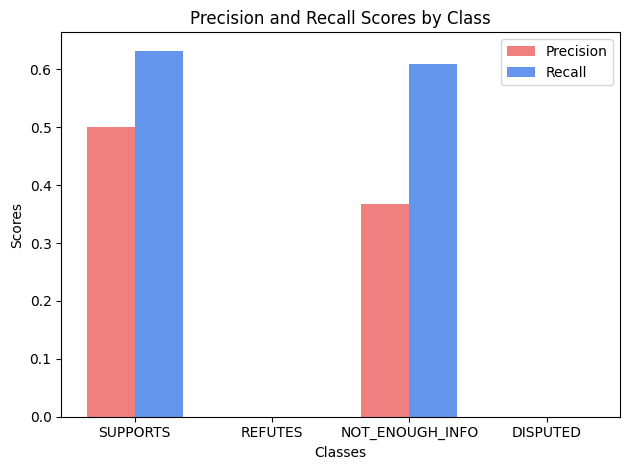

Part 2
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

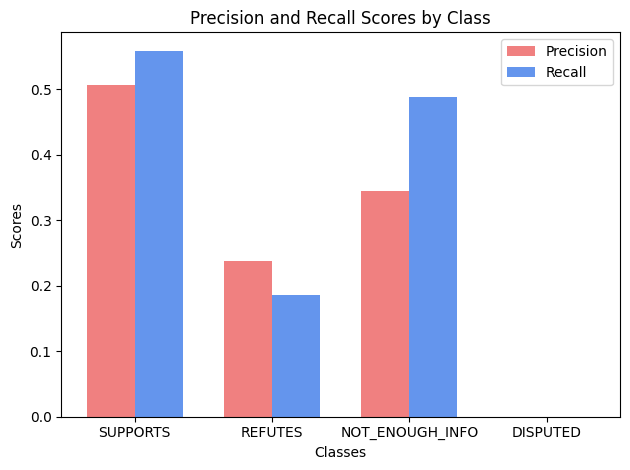

Part 3
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

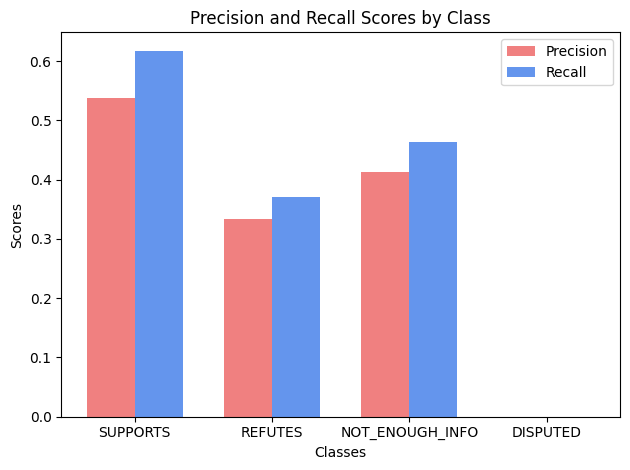

Part 4
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

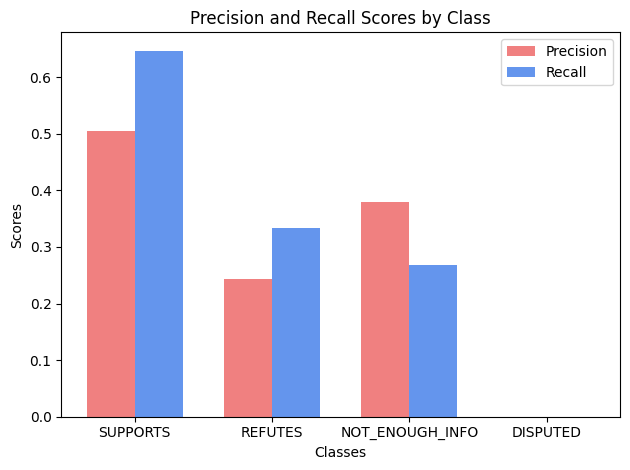

Part 5
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

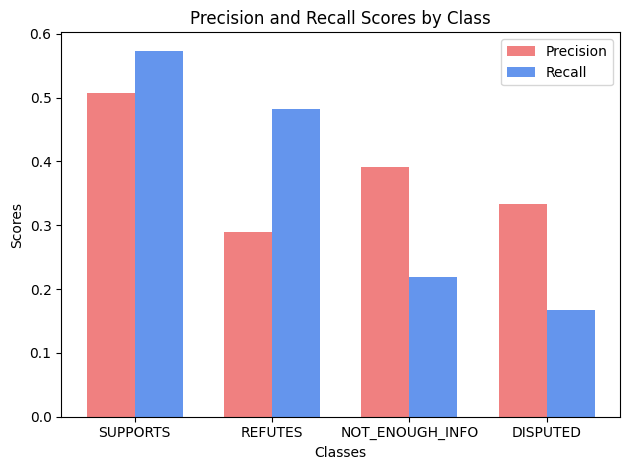

Part 6
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

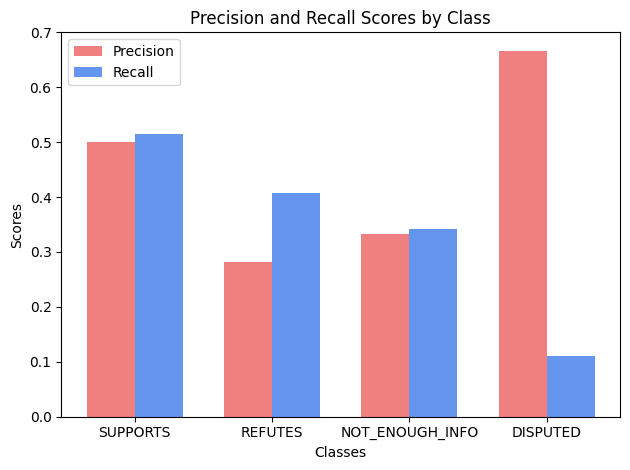

Part 7
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

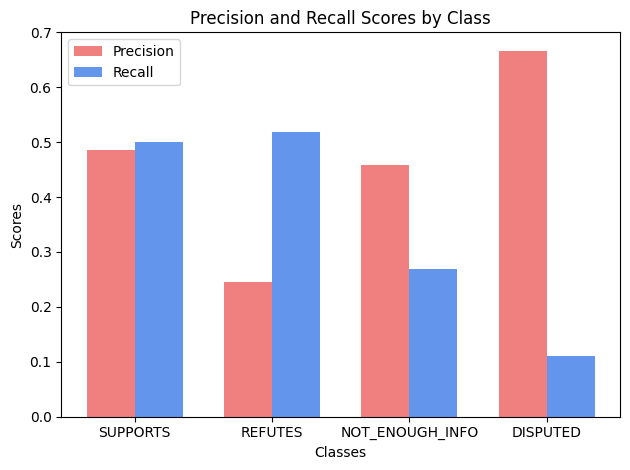

Part 8
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

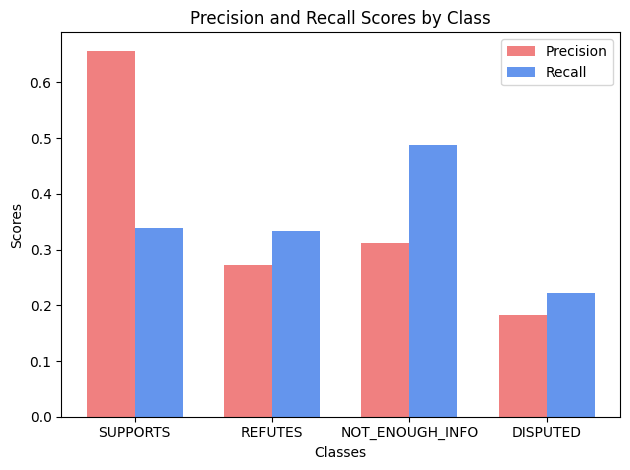

Part 9
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
Tr

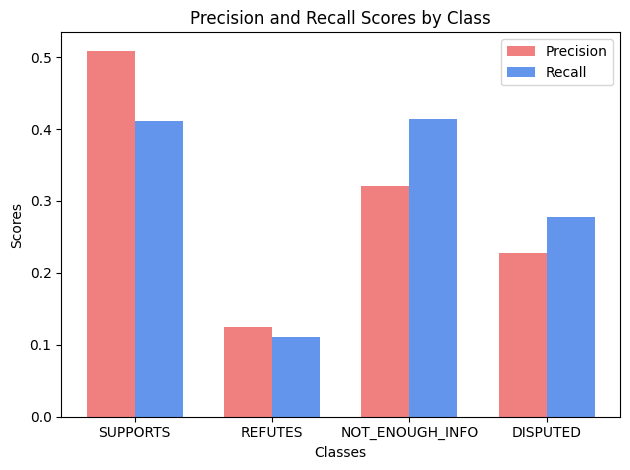

Part 10
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training batch: 28
Training batch: 29
Training batch: 30
Training batch: 31
Training batch: 32
Training batch: 33
Training batch: 34
Training batch: 35
Training batch: 36
Training batch: 37
Training batch: 38
Training batch: 39
Training batch: 40
Training batch: 41
Training batch: 42
Training batch: 43
Training batch: 44
Training batch: 45
Training batch: 46
Training batch: 47
Training batch: 48
Training batch: 49
Training batch: 50
T

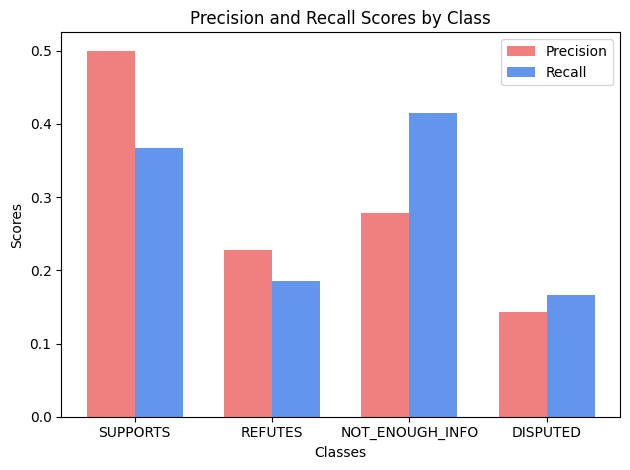

In [ ]:
flatten_train_cv = flatten_data_cv(train_data_cv)
train_dataloader_cv = DataLoader(flatten_train_cv, batch_size=batch_size_train, collate_fn=seq_collate_batch_cv)

cv_dev_performance = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
cv_train_performance = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}

best_accuracy = 0
# Training
print('Number of batch:', len(train_dataloader_cv))
n_epoch = 10
for epoch in range(n_epoch):
    print(f"Part {epoch + 1}\n-------------------------------")
    train_cv(train_dataloader_cv, cv_model, loss_fn, optimizer)

    # dev set evaluation
    precisions, recalls, accuracy, misclassified_dev, correctly_classified_dev, prediction, perdiction_perm  = test_cv(dev_data_cv, cv_model, loss_fn, logging=False)
    print(f'Dev set accuracy: accuracy = {accuracy}')
    plot_per_class_precision_recall(precisions, recalls)
    cv_dev_performance['accuracy'].append(accuracy)
    cv_dev_performance['precision'].append(precisions)
    cv_dev_performance['recall'].append(recalls)
    cv_dev_performance['f1'].append({label:2*(p*recalls[label])/(p+recalls[label]) if p+recalls[label] else 0 for label, p in precisions.items()})

    if accuracy > best_accuracy:
        best_accuracy = accuracy

        torch.save({
            'epoch': epoch+1,
            'model_state_dict': cv_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, folder + model_dir + f'cv_model.tar')

    # train set evaluation
    #precisions, recalls, accuracy, misclassified_dev, correctly_classified_dev, prediction, perdiction_perm = test_cv(train_data_cv, cv_model, loss_fn, logging=False)
    #print(f'Train set accuracy: accuracy = {accuracy}')
    #plot_per_class_precision_recall(precisions, recalls)
    #cv_train_performance['accuracy'].append(accuracy)
    #cv_train_performance['precision'].append(precisions)
    #cv_train_performance['recall'].append(recalls)
    #cv_train_performance['f1'].append({label:2*(p*recalls[label])/(p+recalls[label])  if p+recalls[label] else 0 for label, p in precisions.items()})



Plot cv accuracy over epochs

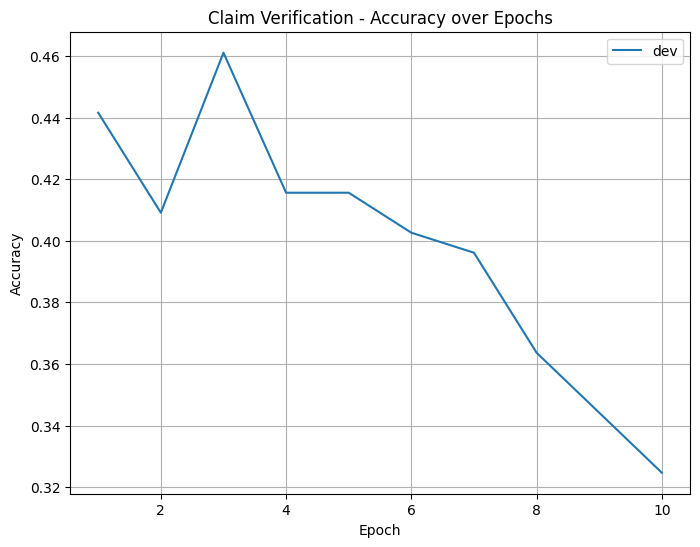

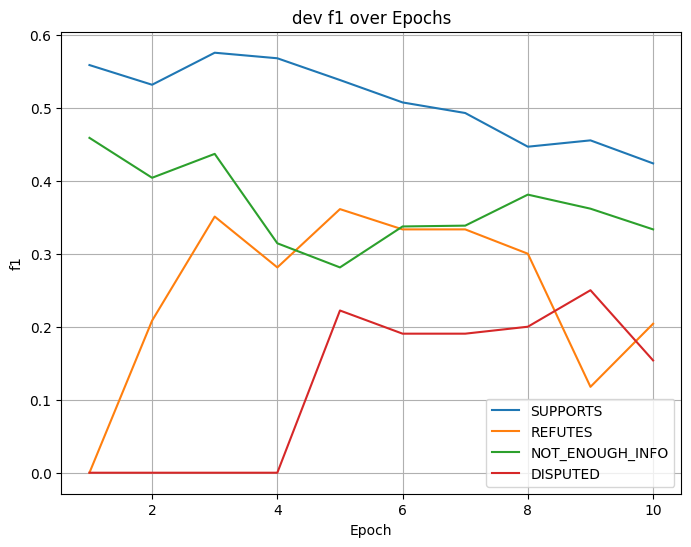

In [ ]:
import matplotlib.pyplot as plt


# accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1,len(cv_dev_performance['accuracy'])+1), cv_dev_performance['accuracy'], label='dev')
#plt.plot(range(1,len(cv_train_performance['accuracy'])+1), cv_train_performance['accuracy'], label='train')

plt.title('Claim Verification - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.savefig(folder + result_dir + 'cv_score_epoch.png')
plt.show()

def plot_per_class_metric_over_episode(metric, performance, set_name):
  plt.figure(figsize=(8, 6))
  for label in label_to_idx.keys():
    metrics = [epoch_performance[label] for epoch_performance in performance[metric]]
    plt.plot(range(1,len(metrics)+1), metrics, label=label)
  plt.title(f'{set_name} {metric} over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.legend()
  plt.grid(True)
  plt.savefig(folder + result_dir + f'cv_{set_name}_{metric}_epoch.png')
  plt.show()

# f1 score
plot_per_class_metric_over_episode('f1', cv_dev_performance, 'dev')
#plot_per_class_metric_over_episode('f1', cv_train_performance, 'train')





Sample permutations, conduct **grid search**.

In [ ]:
import random
def sample_permutation(data_cv, n):
    sampled_data_cv = []
    for data in data_cv:
      sampled_data = {'claim_id':data['claim_id'],
                      'claim_label':data['claim_label'],
                      'training_data':random.sample(data['training_data'], n)}
      sampled_data_cv.append(sampled_data)
    return sampled_data_cv

2 permutations
Number of batch: 20
Part 1
-------------------------------
Dev set accuracy: accuracy = 0.44155844155844154


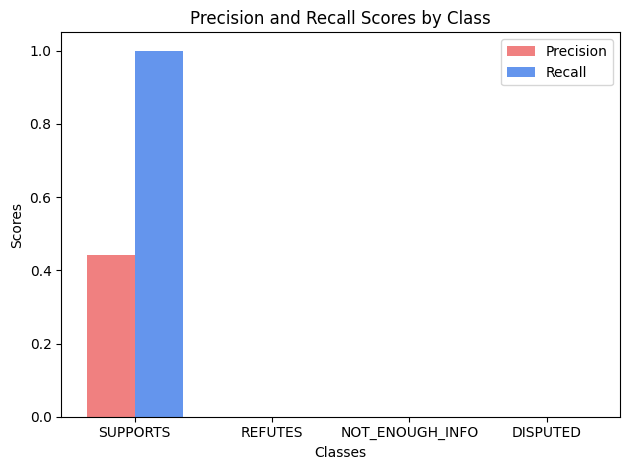

update model: n=2, epoch=0
Part 2
-------------------------------
Dev set accuracy: accuracy = 0.43506493506493504


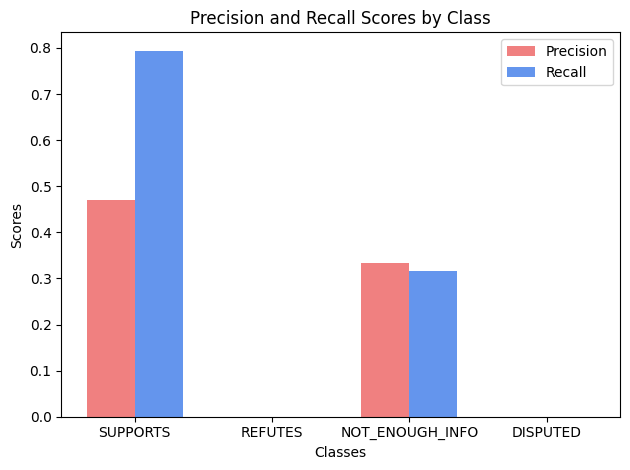

Part 3
-------------------------------
Dev set accuracy: accuracy = 0.4090909090909091


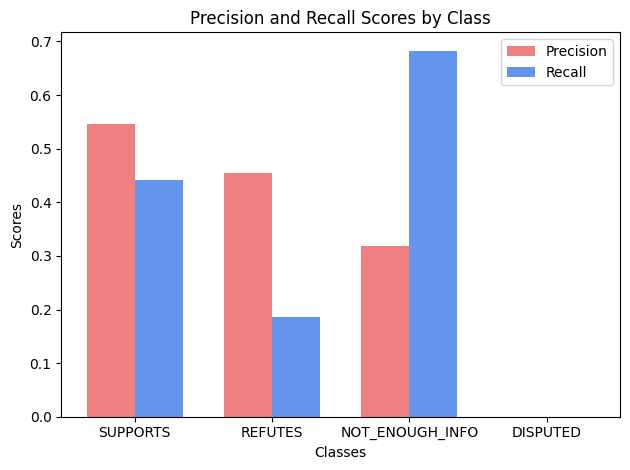

Part 4
-------------------------------
Dev set accuracy: accuracy = 0.38961038961038963


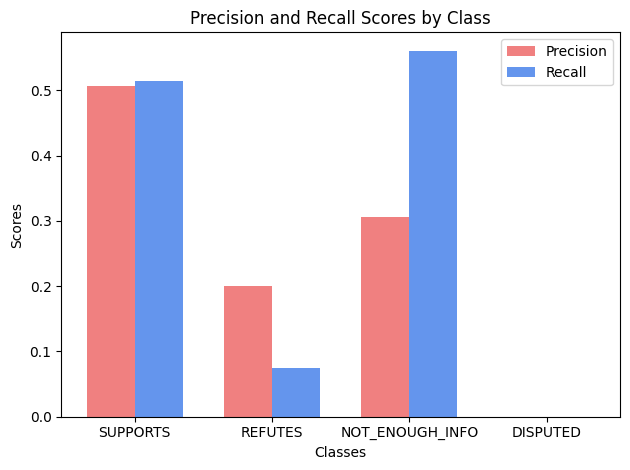

Part 5
-------------------------------
Dev set accuracy: accuracy = 0.36363636363636365


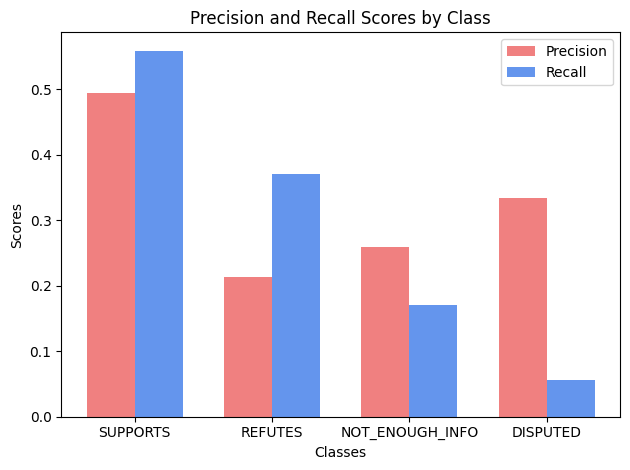

Part 6
-------------------------------
Dev set accuracy: accuracy = 0.4025974025974026


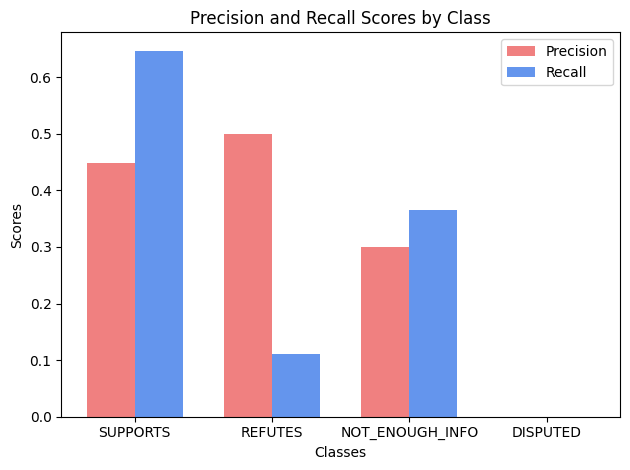

Part 7
-------------------------------
Dev set accuracy: accuracy = 0.44155844155844154


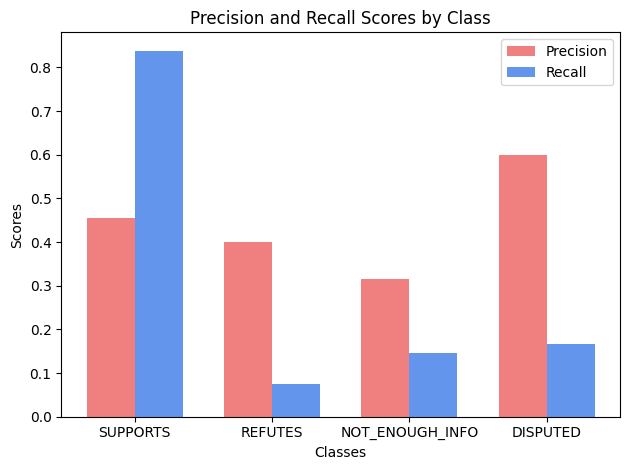

Part 8
-------------------------------
Dev set accuracy: accuracy = 0.4025974025974026


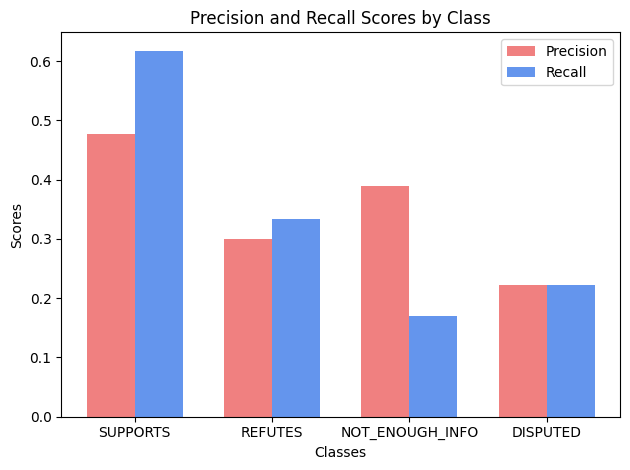

6 permutations
Number of batch: 58
Part 1
-------------------------------
Dev set accuracy: accuracy = 0.43506493506493504


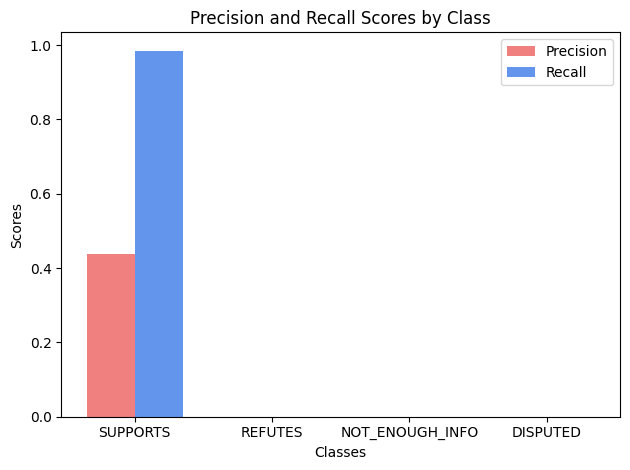

Part 2
-------------------------------
Dev set accuracy: accuracy = 0.4025974025974026


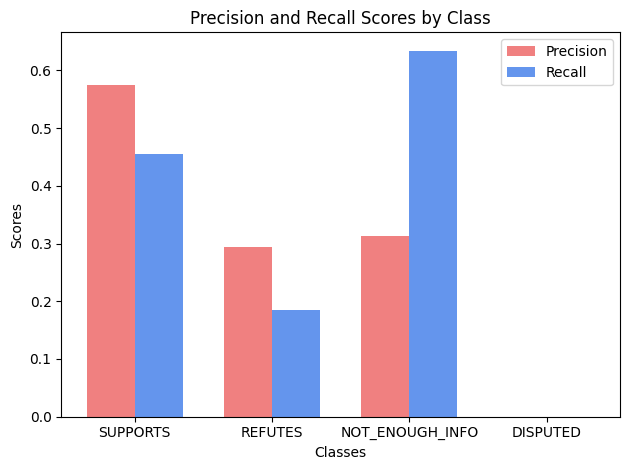

Part 3
-------------------------------
Dev set accuracy: accuracy = 0.4025974025974026


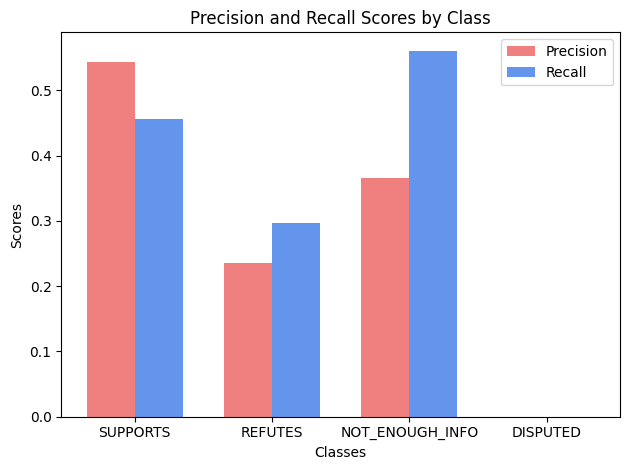

Part 4
-------------------------------
Dev set accuracy: accuracy = 0.35714285714285715


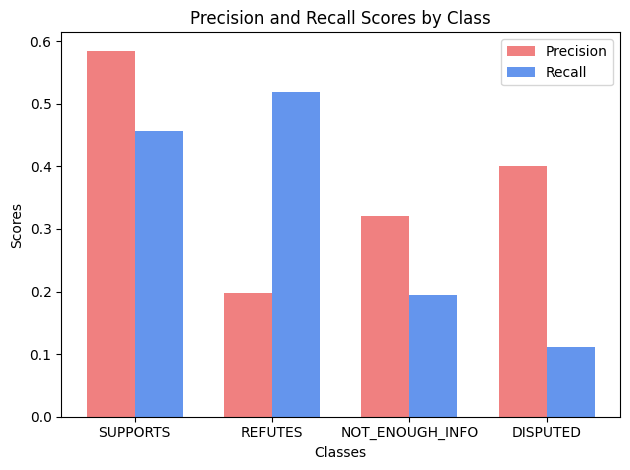

Part 5
-------------------------------
Dev set accuracy: accuracy = 0.33116883116883117


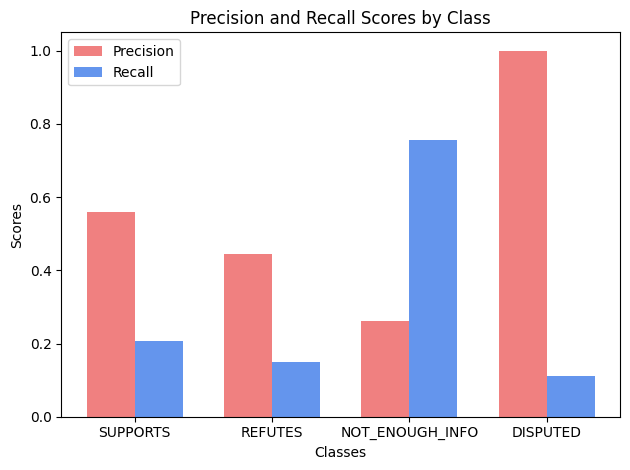

Part 6
-------------------------------
Dev set accuracy: accuracy = 0.4025974025974026


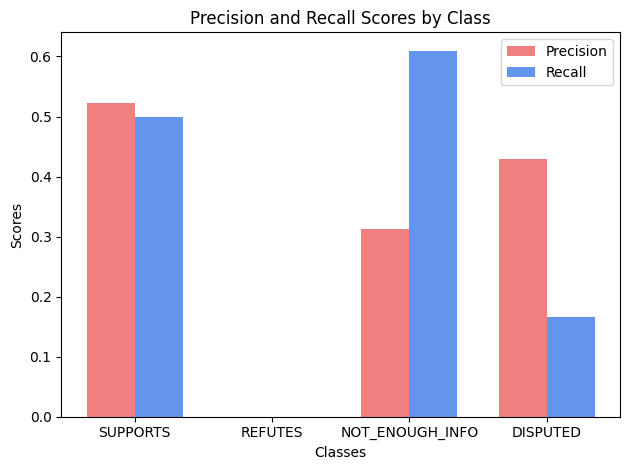

Part 7
-------------------------------
Dev set accuracy: accuracy = 0.4155844155844156


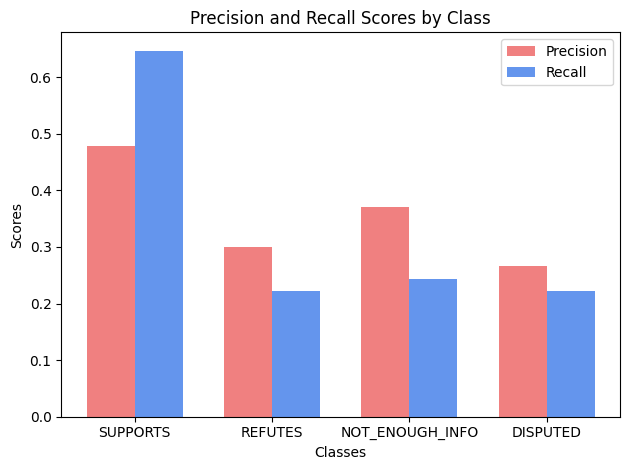

Part 8
-------------------------------
Dev set accuracy: accuracy = 0.43506493506493504


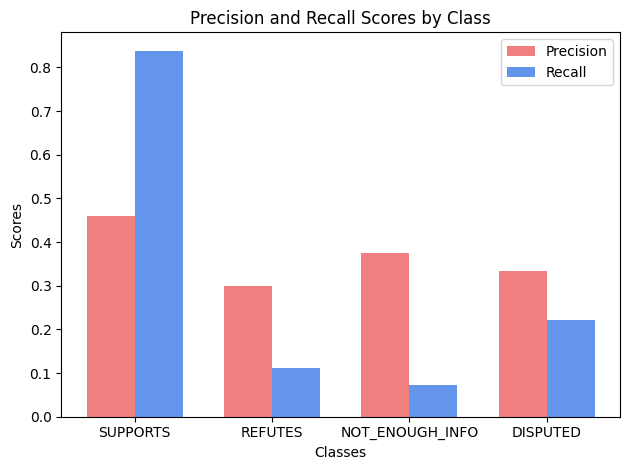

12 permutations
Number of batch: 116
Part 1
-------------------------------
Dev set accuracy: accuracy = 0.4155844155844156


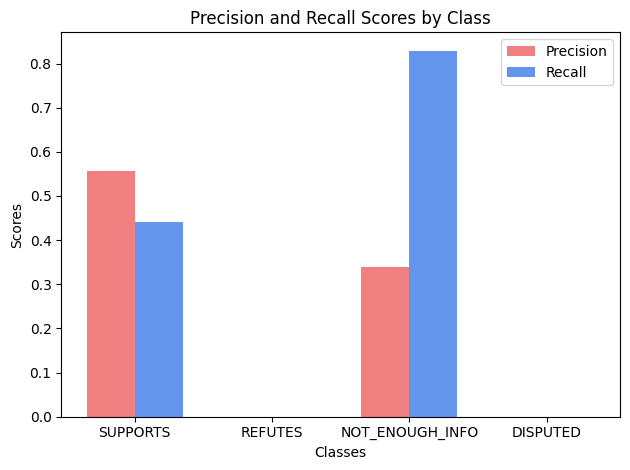

Part 2
-------------------------------
Dev set accuracy: accuracy = 0.38961038961038963


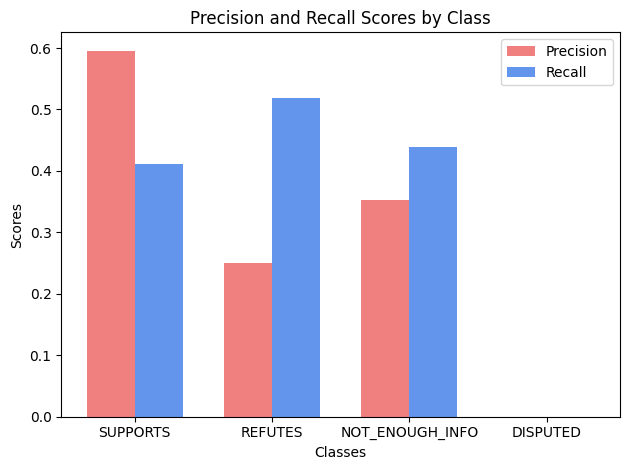

Part 3
-------------------------------
Dev set accuracy: accuracy = 0.44805194805194803


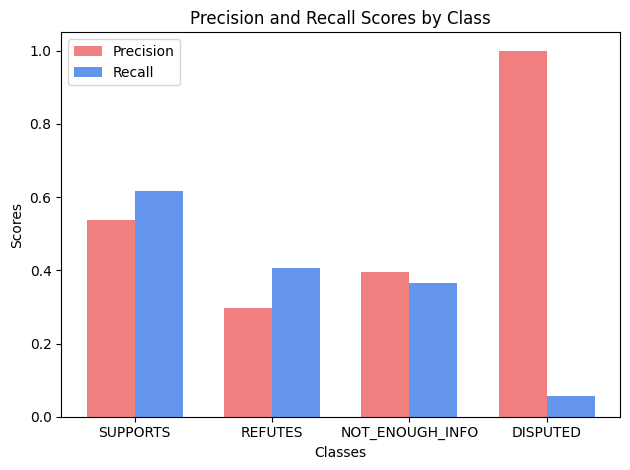

update model: n=12, epoch=2
Part 4
-------------------------------
Dev set accuracy: accuracy = 0.38311688311688313


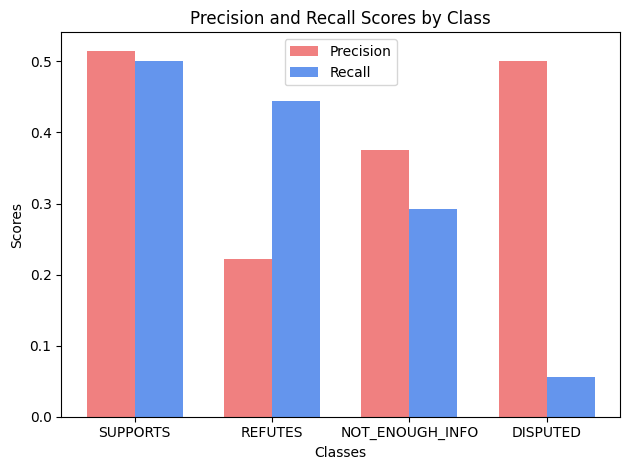

Part 5
-------------------------------
Dev set accuracy: accuracy = 0.3116883116883117


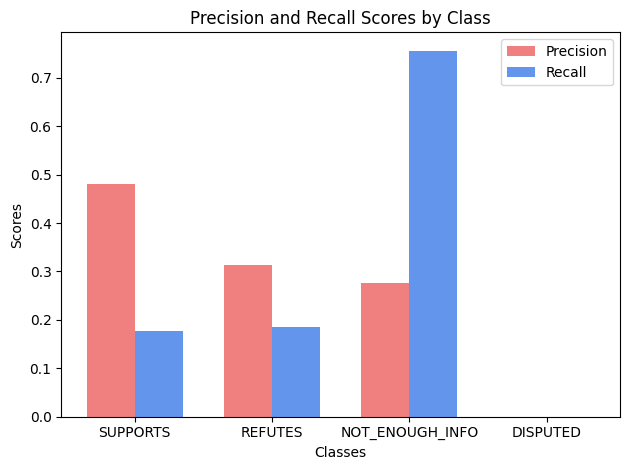

Part 6
-------------------------------
Dev set accuracy: accuracy = 0.2922077922077922


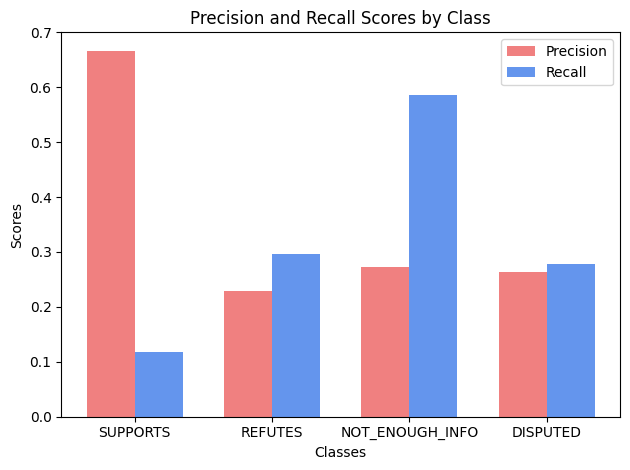

Part 7
-------------------------------
Dev set accuracy: accuracy = 0.35064935064935066


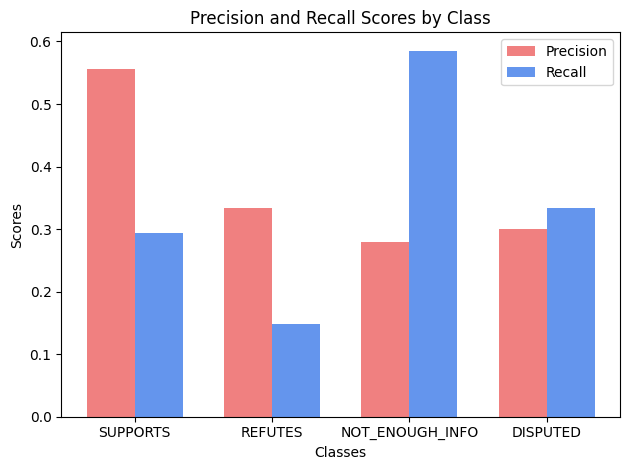

Part 8
-------------------------------
Dev set accuracy: accuracy = 0.3961038961038961


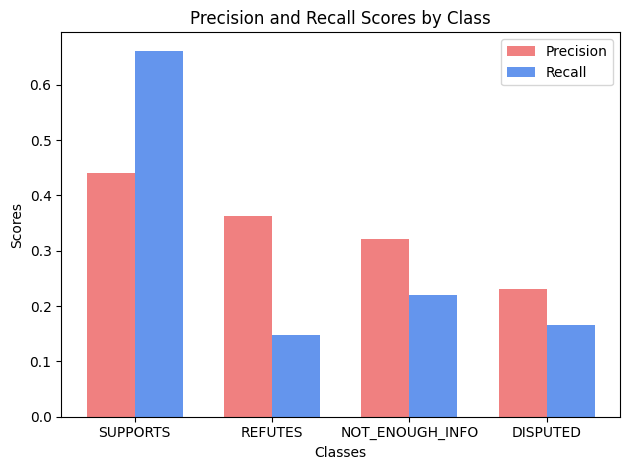

20 permutations
Number of batch: 192
Part 1
-------------------------------
Dev set accuracy: accuracy = 0.44155844155844154


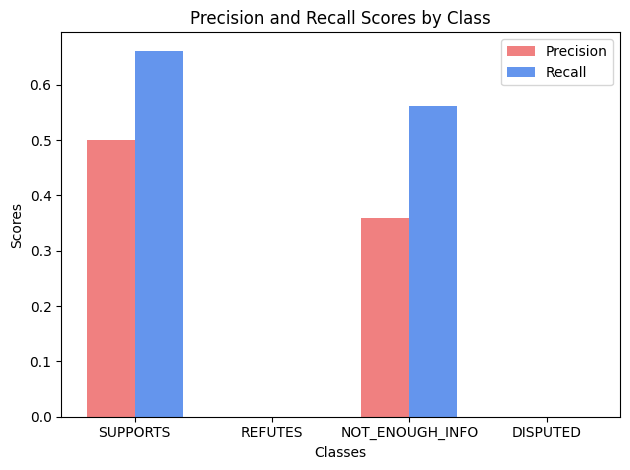

Part 2
-------------------------------
Dev set accuracy: accuracy = 0.474025974025974


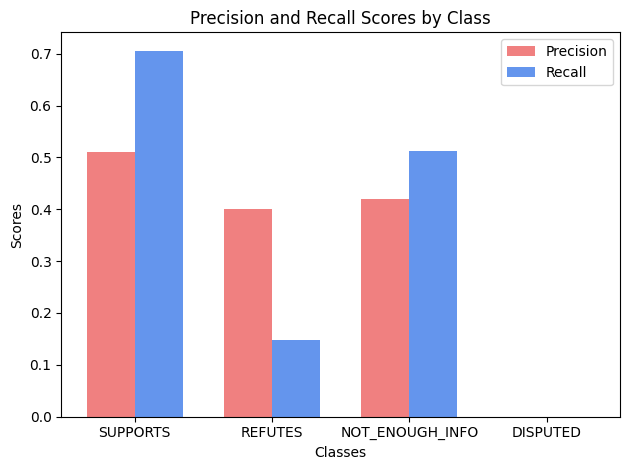

update model: n=20, epoch=1
Part 3
-------------------------------
Dev set accuracy: accuracy = 0.44805194805194803


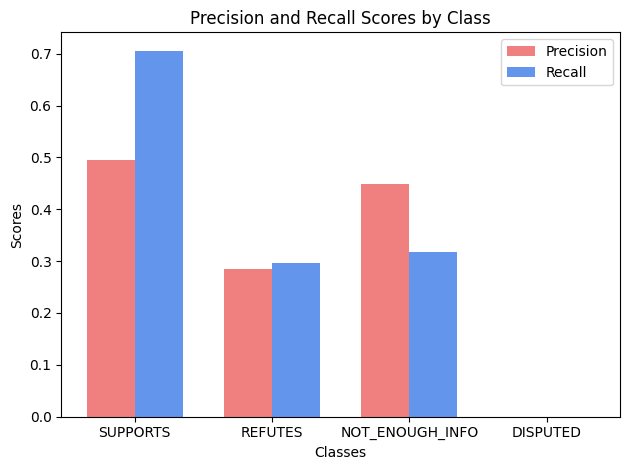

Part 4
-------------------------------
Dev set accuracy: accuracy = 0.45454545454545453


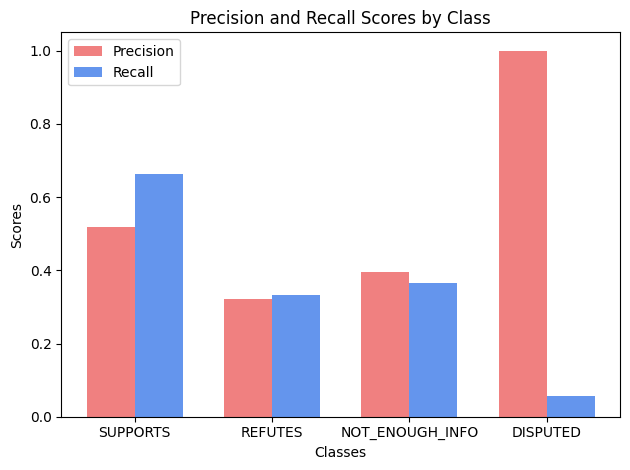

Part 5
-------------------------------
Dev set accuracy: accuracy = 0.33766233766233766


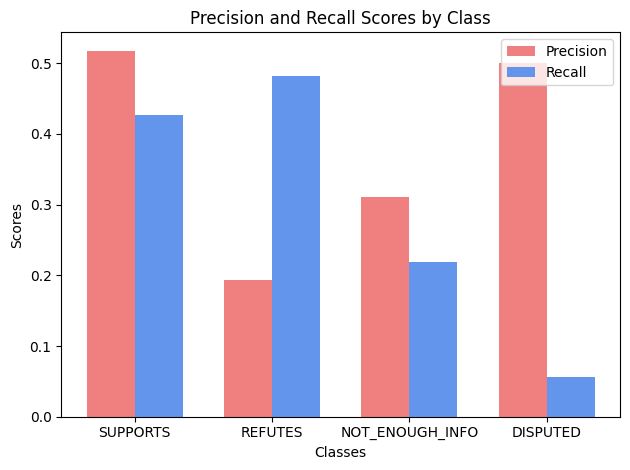

Part 6
-------------------------------
Dev set accuracy: accuracy = 0.37012987012987014


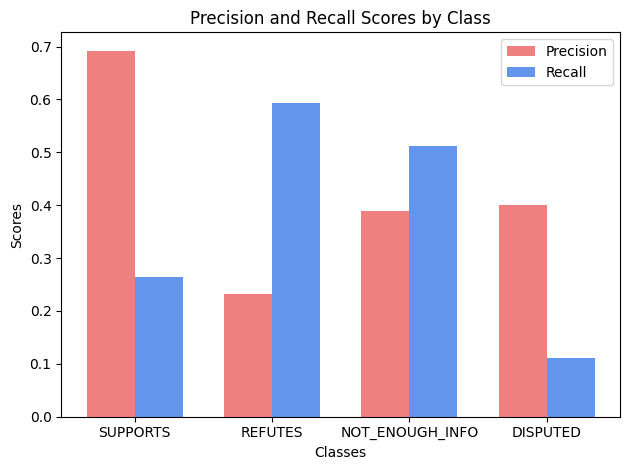

Part 7
-------------------------------
Dev set accuracy: accuracy = 0.37662337662337664


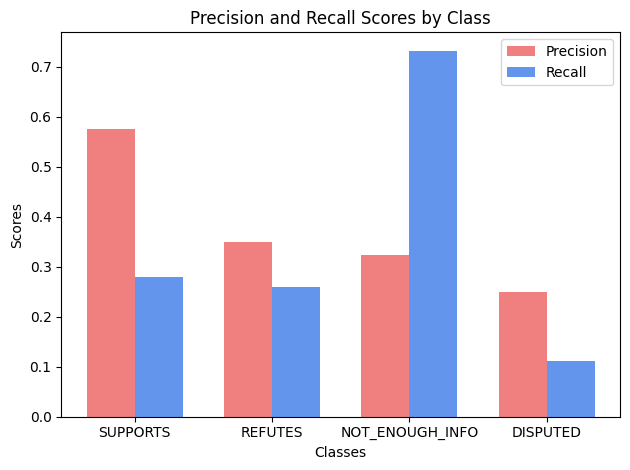

Part 8
-------------------------------
Dev set accuracy: accuracy = 0.36363636363636365


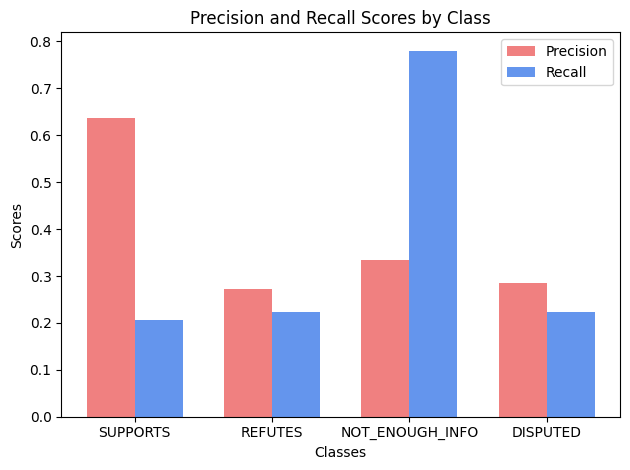

In [ ]:
best_accuracy = 0
best_n = 0
best_epoch = 0
dev_performances = {}

for n in [2, 6, 12, 20]:
  print(f"{n} permutations")
  cv_model = CVModel(d0).to(device)
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(cv_model.parameters(), lr=0.001)

  data_cv_sample = sample_permutation(train_data_cv, n)
  flatten_cv_sample = flatten_data_cv(data_cv_sample)
  dataloader_cv_sample = DataLoader(flatten_cv_sample, batch_size=batch_size_train, collate_fn=seq_collate_batch_cv)

  cv_dev_performance = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
  cv_train_performance = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}

  # Training
  print('Number of batch:', len(dataloader_cv_sample))
  n_epoch = 8
  for epoch in range(n_epoch):
      print(f"Part {epoch + 1}\n-------------------------------")
      train_cv(dataloader_cv_sample, cv_model, loss_fn, optimizer, logging=False)

      # dev set evaluation
      precisions, recalls, accuracy, misclassified_dev, correctly_classified_dev, prediction, perdiction_perm  = test_cv(dev_data_cv, cv_model, loss_fn, logging=False)
      print(f'Dev set accuracy: accuracy = {accuracy}')
      plot_per_class_precision_recall(precisions, recalls)
      cv_dev_performance['accuracy'].append(accuracy)
      cv_dev_performance['precision'].append(precisions)
      cv_dev_performance['recall'].append(recalls)
      cv_dev_performance['f1'].append({label:2*(p*recalls[label])/(p+recalls[label]) if p+recalls[label] else 0 for label, p in precisions.items()})

      # get best hyperparameters
      if accuracy > best_accuracy:
          print(f"update model: n={n}, epoch={epoch}")
          best_accuracy = accuracy
          best_n = n
          best_epoch = epoch
          torch.save({
              'epoch': epoch+1,
              'model_state_dict': cv_model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              }, folder + model_dir + f'cv_model_{n}_{epoch}.tar')

  dev_performances[n] = cv_dev_performance


In [ ]:
# concatenate with accuracies of n=24 from previous cell
dev_performances[24] = {'accuracy':[0.44155844155844154,0.4090909090909091,0.461038961038961, 0.4155844155844156, 0.4155844155844156, 0.4025974025974026, 0.3961038961038961, 0.36363636363636365]}

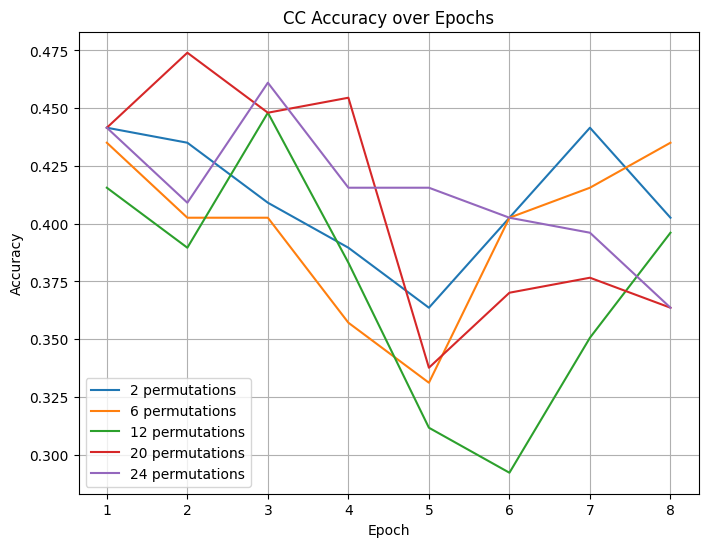

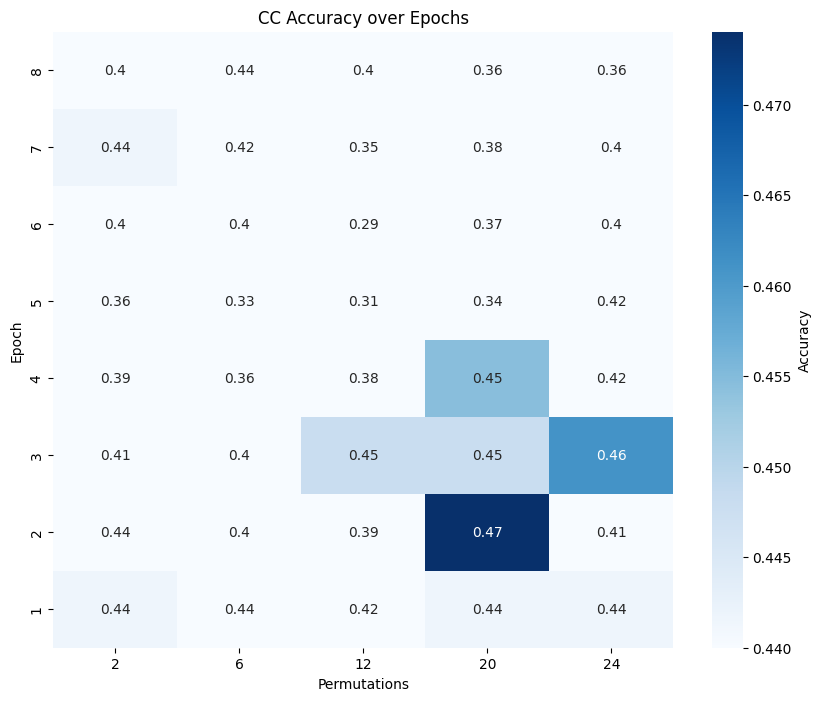

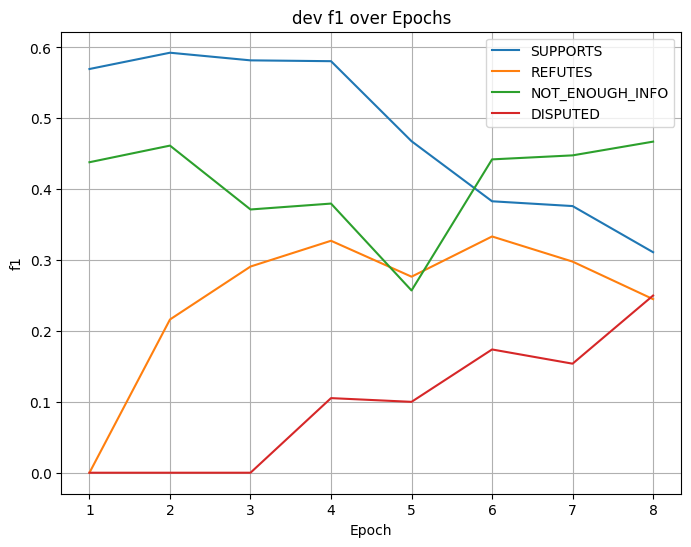

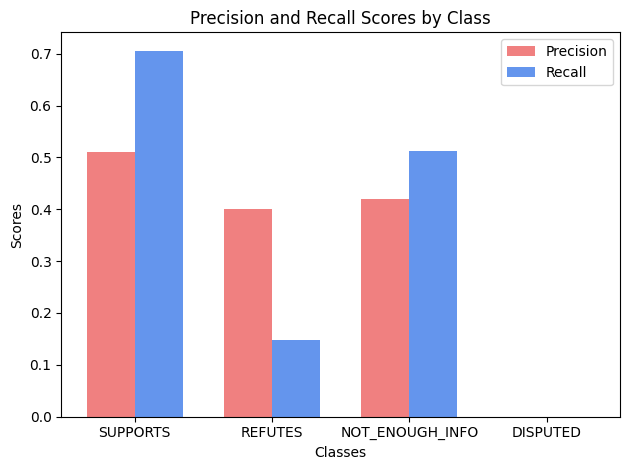

0.44155844155844154


In [ ]:
# plot accuracy line graph
plt.figure(figsize=(8, 6))
for n in [2, 6, 12, 20, 24]:
  plt.plot(range(1,len(dev_performances[n]['accuracy'])+1), dev_performances[n]['accuracy'], label=f'{n} permutations')

plt.title('CC Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.savefig(folder + result_dir + 'cv_accuracy_epoch_n.png')
plt.show()

# plot accuracy heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
permutations = [2, 6, 12, 20, 24]
max_epochs = 8

accuracy_matrix = np.zeros((max_epochs, len(permutations)))
for i, n in enumerate(permutations):
    accuracies = dev_performances[n]['accuracy']
    accuracy_matrix[:len(accuracies), i] = accuracies

plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, annot=True, cmap='Blues', cbar_kws={'label': 'Accuracy'}, vmin=0.44)
plt.title('CC Accuracy over Epochs')
plt.xlabel('Permutations')
plt.ylabel('Epoch')
plt.xticks(ticks=np.arange(len(permutations)) + 0.5, labels=permutations)
plt.yticks(ticks=np.arange(max_epochs) + 0.5, labels=range(1, max_epochs + 1))
plt.gca().invert_yaxis()
plt.show()


# plot per class f1 score of best number of permutations, over epochs
plot_per_class_metric_over_episode('f1', dev_performances[best_n], 'dev')

# plot per class precision and recall under the best hyperparameters
plot_per_class_precision_recall(dev_performances[best_n]['precision'][best_epoch], dev_performances[best_n]['recall'][best_epoch])

print(sum([claim['claim_label']=='SUPPORTS' for claim in dev_claims])/len(dev_claims))

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

**Final Evidence Retrieval Model**

Training with train + dev set

In [ ]:
print("Training Evidence Retrieval model for final evaluation!")
d0 = 128

model = ERModel(d0).to(device)
print(model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

neg_samples_nums = [1500, 1200, 1000]

for i, neg_samples_num in enumerate(neg_samples_nums):
  print('epoch', i+1)
  for part in range(1, 9):
    train_data = np.load(folder + train_data_dir + f'trainDev_data_{part}_{neg_samples_num}neg.npy', allow_pickle=True)
    flatten_train_data = flatten_data(train_data)
    train_dataloader = DataLoader(flatten_train_data, batch_size=batch_size_train, collate_fn=seq_collate_batch)
    print('Number of batch in train:', len(train_dataloader))
    train(train_dataloader, model, loss_fn, optimizer)

Test with train, dev and test set to output prediction for claim verification final model training

In [ ]:
import json

for dataset_name in ['dev', 'test']:
  test_data = np.load(folder + train_data_dir + f'{dataset_name}_data_3000nn.npy', allow_pickle=True)
  test_test_claims(test_data, model, dataset_name, is_final_model=True)

In [ ]:
for part in range(1, 9):
  test_data = np.load(folder + train_data_dir + f'train_data_{part}_3000nn.npy', allow_pickle=True)
  test_test_claims(test_data, model, 'train', part, is_final_model=True)

# Merge the ER prediction for train claims and save it
train_claims_predict_total = {}
for part in range(1, 9):
    train_claims_predict_part = load_data(folder + result_dir + f'evidence_retrieval_train_data_{part}_predict_final.json')
    for claim_id, evidences in train_claims_predict_part.items():
        train_claims_predict_total[claim_id] = evidences

with open(folder + result_dir + 'evidence_retrieval_train_data_predict_final', 'w') as f:
      json.dump(train_claims_predict_total, f)

**Final Claim Verification Model**

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def test_seq_collate_batch_cv(batch):
    claim_list, evidence_list = [], []
    for record in batch:
        claim_list.append(record[0])
        evidence_list.append(record[1])

    claim_text_tensor = []
    for claim in claim_list:
        padded_seq = torch.tensor(claim[:claim_max_len], dtype=torch.float32)
        add_padding = torch.tensor([padding_embedding] * (claim_max_len - len(padded_seq)), dtype=torch.float32)
        padded_seq = torch.concat((padded_seq, add_padding), dim=0)
        claim_text_tensor.append(padded_seq)
    claim_list = torch.stack(claim_text_tensor)

    evidence_list_tensor = []
    for evidence in evidence_list:
        padded_seq = torch.tensor(evidence[:evidence_max_len], dtype=torch.float32)
        add_padding = torch.tensor([padding_embedding] * (evidence_max_len - len(padded_seq)), dtype=torch.float32)
        padded_seq = torch.concat((padded_seq, add_padding), dim=0)
        evidence_list_tensor.append(padded_seq)
    evidence_list = torch.stack(evidence_list_tensor)

    # print(claim_list.shape, evidence_list.shape, label_list.shape)

    # Stack all sequences into a single tensor for each batch
    return claim_list.to(device), evidence_list.to(device)

def predict(data, model):
    num_batches = 0

    # After calling eval(), the model no longer caching steps and gradient.
    # The model also does the inference faster with less resource.
    model.eval()
    num_claims = len(data)
    predicted_labels = {}
    predictedLabelPerm = {}
    # This line specify that there will be no gradient in the operation below.
    with torch.no_grad():
        for i, data_for_claim_id in enumerate(data):
          print('Testing claim:', i, data_for_claim_id['claim_id'])

          # batch_size=1 since only 1 record for claim
          dataloader = DataLoader(data_for_claim_id['training_data'], batch_size=1, collate_fn=test_seq_collate_batch_cv)
          num_batches += len(dataloader)

          for (claim_embedding, evidence_embedding) in dataloader:
              pred = model(claim_embedding, evidence_embedding)
              pred = torch.flatten(pred)
              predictions = {idx_to_label[i]:pred[i].item() for i in range(4)}
              predicted_label = idx_to_label[torch.max(pred.unsqueeze(0), dim=1)[1].item()]
              if data_for_claim_id['claim_id'] in predictedLabelPerm:
                  predictedLabelPerm[data_for_claim_id['claim_id']].append(predicted_label)
              else:
                  predictedLabelPerm[data_for_claim_id['claim_id']]=[predicted_label]

          counter = Counter(predictedLabelPerm[data_for_claim_id['claim_id']])
          predicted_label = counter.most_common(1)[0][0]
          predicted_labels[data_for_claim_id['claim_id']] = predicted_label
          print(f"{data_for_claim_id['claim_id']}, predicted: {predicted_label}, counts: {counter}\n")

    with open(folder + result_dir + f'claim_verification_test_data_predict_final.json', 'w') as f:
      json.dump(predicted_labels, f)

    return predicted_labels

Training with train + dev set

In [ ]:
train_er_predict_final = load_data(folder + result_dir + 'evidence_retrieval_train_data_predict_final_model.json')
train_data_cv_final = process_er_data(train_claims, train_er_predict_final)
np.save(folder + train_data_dir + 'train_data_cv_final_perm', train_data_cv_final)

dev_er_predict_final = load_data(folder + result_dir + 'evidence_retrieval_dev_data_predict_final_model.json')
dev_data_cv_final = process_er_data(dev_claims, dev_er_predict_final)
np.save(folder + train_data_dir + 'dev_data_cv_final_perm', dev_data_cv_final)

train_dev_cv = train_data_cv_final + dev_data_cv_final

# Have to run the cells in 3.Testing and Evaluation evidence retrieval section first to get
# the evidence retrieval prediction for test claims
test_er_predict = load_data(folder + result_dir + 'evidence_retrieval_test_data_predict.json')
test_data_cv = process_er_data(test_claims, test_er_predict)
np.save(folder + train_data_dir + 'test_data_cv_final_perm', test_data_cv)

In [ ]:
import numpy as np
test_er_predict = load_data(folder + result_dir + 'evidence_retrieval_test_data_predict.json')
train_data_cv_final = np.load(folder + train_data_dir + 'train_data_cv_final_perm.npy', allow_pickle=True)
dev_data_cv_final = np.load(folder + train_data_dir + 'dev_data_cv_final_perm.npy', allow_pickle=True)
dev_data_cv_final = dev_data_cv_final.reshape((dev_data_cv_final.shape[0], 1))
train_dev_cv = np.concatenate((train_data_cv_final,dev_data_cv_final.flatten()))
test_data_cv = np.load(folder + train_data_dir + 'test_data_cv_final_perm.npy', allow_pickle=True)

In [ ]:
print("Training LSTM network model!")
d0 = 128 + n_extra_features

cv_model_final = CVModel(d0).to(device)
print(cv_model_final)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(cv_model_final.parameters(), lr=0.001)

train_dev_cv = sample_permutation(train_dev_cv, best_n)
flatten_train_dev_cv = flatten_data_cv(train_dev_cv)
train_dev_dataloader_cv = DataLoader(flatten_train_dev_cv, batch_size=batch_size_train, collate_fn=seq_collate_batch_cv)

# Training
print('Number of batch:', len(train_dev_dataloader_cv))

n_epoch = best_epoch + 1
for epoch in range(n_epoch):
    print(f"Part {epoch + 1}\n-------------------------------")
    train_cv(train_dev_dataloader_cv, cv_model_final, loss_fn, optimizer)

Training LSTM network model!
CVModel(
  (lstm1): LSTM(137, 137, batch_first=True, bidirectional=True)
  (alignment_linear): Linear(in_features=1096, out_features=274, bias=True)
  (relu): ReLU()
  (lstm2): LSTM(411, 274, batch_first=True, bidirectional=True)
  (output_linear1): Linear(in_features=2192, out_features=548, bias=True)
  (output_linear2): Linear(in_features=548, out_features=4, bias=True)
)
Number of batch: 216
Part 1
-------------------------------
Training batch: 0
Training batch: 1
Training batch: 2
Training batch: 3
Training batch: 4
Training batch: 5
Training batch: 6
Training batch: 7
Training batch: 8
Training batch: 9
Training batch: 10
Training batch: 11
Training batch: 12
Training batch: 13
Training batch: 14
Training batch: 15
Training batch: 16
Training batch: 17
Training batch: 18
Training batch: 19
Training batch: 20
Training batch: 21
Training batch: 22
Training batch: 23
Training batch: 24
Training batch: 25
Training batch: 26
Training batch: 27
Training bat

Prediction for testing claims

In [ ]:
test_predictions = predict(test_data_cv, cv_model_final)

Testing claim: 0 claim-2967
claim-2967, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 13, 'REFUTES': 11})

Testing claim: 1 claim-979
claim-979, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 2 claim-1609
claim-1609, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 3 claim-1020
claim-1020, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 4 claim-2599
claim-2599, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 5 claim-2110
claim-2110, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 6 claim-1135
claim-1135, predicted: NOT_ENOUGH_INFO, counts: Counter({'NOT_ENOUGH_INFO': 24})

Testing claim: 7 claim-712
claim-712, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 8 claim-1307
claim-1307, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 9 claim-148
claim-148, predicted: SUPPORTS, counts: Counter({'SUPPORTS': 24})

Testing claim: 10

In [ ]:
predictions_count = {label:0 for label in label_to_idx.keys()}
for c_id, c_predict in test_predictions.items():
    predictions_count[c_predict] += 1
predictions_count

{'SUPPORTS': 107, 'REFUTES': 3, 'NOT_ENOUGH_INFO': 43, 'DISPUTED': 0}

Combine EV and CC result

In [ ]:
import copy
er_cv_result = {}
for claim in test_claims:
    c_id = claim['claim_id']
    er_cv_result[c_id] = {"claim_text":claim['claim_text'],
                          "claim_label":test_predictions[c_id],
                          "evidences": test_er_predict[c_id]}
with open(folder + result_dir + 'test_predictions_final.json', "w") as fp:
    json.dump(er_cv_result, fp)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*